# Applying Artificial Neural Network (ANN) Algorithm 

This notebook explores the application of the Artificial Neural Network (ANN) algorithm to our data. We will use the ANN algorithm, play with its parameters and analyze its performance in making predictions based on our dataset.

Here, we will:

* Apply ANN to our data for regression and try different combinations of its parameters.
* Evaluate the ANN model's performance using metrics Mean Squared Error, R-squared, and Mean Absolute Error.
* Explore the impact of different parameter values on the model's performance.


In [1]:
import tensorflow as tf

# Configure GPU device
config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True  # Optional memory growth strategy
session = tf.compat.v1.Session(config=config)

# Rest of your TensorFlow code using the session


In [2]:
print(tf.config.list_physical_devices('CPU'))

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
from sklearn.model_selection import train_test_split
from sklearn.discriminant_analysis import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

In [5]:
from tensorflow import keras
from tensorflow.keras import layers

In [6]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input, Dropout
from tensorflow.keras.callbacks import EarlyStopping



## Helper Functions

In [7]:
def create_custom_model(X_train, y_train, batch_size=32):
    # Define the ANN model with dropout and early stopping
    model = keras.Sequential([
        layers.Dense(32, activation="relu", input_shape=(X_train.shape[1],)),  # Input layer
        layers.Dropout(0.2),  # Dropout layer with 20% dropout rate
        layers.Dense(16, activation="tanh"),  # Hidden layer
        layers.Dropout(0.2),
        layers.Dense(1)  # Output layer for regression
    ])
    
    # Early stopping callback
    early_stopping = EarlyStopping(monitor='loss', patience=5)
    
    # Compile the model (specifies loss function and optimizer)
    model.compile(loss="mae", optimizer="adam")  # Use 'mse' for regression


    # Train the model
    model.fit(X_train, y_train, epochs=100, batch_size=batch_size, callbacks=[early_stopping])  # Adjust epochs and batch size
    return model


In [8]:
def create_model(X_train, y_train, hidden_layer_sizes=(50,), activation='relu', optimizer='adam', dropout=0.1, epochs=100):
    input_shape = X_train.shape[1]
    num_classes = 1

    model = Sequential()
    model.add(Input(shape=(input_shape,)))

    for layer_size in hidden_layer_sizes:
        model.add(Dense(layer_size, activation=activation))
        model.add(Dropout(dropout))

    model.add(Dense(num_classes, activation=activation))

    # Early stopping callback
    early_stopping = EarlyStopping(monitor='loss', patience=5)

    model.compile(loss='mean_squared_error', optimizer=optimizer)
    model.fit(X_train, y_train, epochs=epochs, callbacks=[early_stopping])
    return model


In [9]:
models_results = []

In [10]:
def evaluate_model(model, X_train, y_train, X_test, y_test, zone="Whole City"):
    # Predict on training and testing data
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    
    # Calculate metrics for training data
    train_mse = mean_squared_error(y_train, y_train_pred)
    train_mae = mean_absolute_error(y_train, y_train_pred)
    train_r2 = r2_score(y_train, y_train_pred)
    
    # Calculate metrics for testing data
    test_mse = mean_squared_error(y_test, y_test_pred)
    test_mae = mean_absolute_error(y_test, y_test_pred)
    test_r2 = r2_score(y_test, y_test_pred)

    # Print the metrics
    print("====== Train ========")
    print(f"Training MSE: {train_mse:.7f}")
    print(f"Training MAE: {train_mae:.7f}")
    print(f"Training R-squared: {train_r2:.7f}")
    print("====== Test ========")
    print(f"Testing MSE: {test_mse:.7f}")
    print(f"Testing MAE: {test_mae:.7f}")
    print(f"Testing R-squared: {test_r2:.7f}")
    print(f"Model: {model.summary()}")

    
    new_row = {
        "Zone": zone,
        "Model": model.name,
        "Train MSE": train_mse,
        "Train MAE": train_mae,
        "Train R2": train_r2,
        "Test MSE": test_mse,
        "Test MAE": test_mae,
        "Test R2": test_r2
    }
    
  
    models_results.append(new_row)

In [11]:
def preprocess_data(df):
    # Melt the DataFrame to long format
    df_melted = df.melt(id_vars=['Zone', 'Model'], 
                        value_vars=['Train MSE', 'Train MAE', 'Train R2', 'Test MSE', 'Test MAE', 'Test R2'],
                        var_name='Metric', value_name='Value')

    # Split Metric into Data Type (Train/Test) and Actual Metric for easier plotting
    df_melted[['Data Type', 'Metric']] = df_melted['Metric'].str.split(' ', expand=True)
    
    return df_melted

In [12]:
def plot_results(df_melted):
   
    # Get unique metrics
    unique_metrics = df_melted['Metric'].unique()
    
    # Set the plot style
    sns.set(style="whitegrid")

    # Loop through each metric and create a separate plot
    for metric in unique_metrics:
        # Filter data for training and testing separately
        train_data = df_melted[(df_melted['Metric'] == metric) & (df_melted['Data Type'] == 'Train')]
        test_data = df_melted[(df_melted['Metric'] == metric) & (df_melted['Data Type'] == 'Test')]
        
        # Create separate plots for training and testing data
        for data, data_type in zip([train_data, test_data], ['Train', 'Test']):
            g = sns.catplot(
                data=data, kind="bar",
                x="Zone", y="Value", hue="Model",
                height=4, aspect=2, sharey=False
            )

            # Set plot titles and labels
            g.set_titles("{col_name} - " + metric)
            g.set_axis_labels(data_type + " " + str(metric), "Value")
            g.set_xticklabels(rotation=45)  
            
            # Adjust legend position and font size
            g._legend.set_bbox_to_anchor((1.1, 0.5))  
            g._legend.set_title('Model')  

            # Display the plot
            plt.tight_layout()
            plt.show()

## Initial Modeling Approach: Raw Data

We will begin our exploration by applying the ANN algorithm directly to the original data, **without** any preprocessing steps. This initial approach will serve as a baseline for comparison as we investigate the potential benefits of data preprocessing techniques we applied.


In [13]:
df_original = pd.read_csv('data/data.csv')

df_original.drop("DateTime", inplace=True, axis=1)

In [14]:
df_original.rename(columns={
    "Zone 1 Power Consumption": "z1",
    "Zone 2  Power Consumption": "z2",
    "Zone 3  Power Consumption": "z3"
}, inplace=True)

In [15]:
df_z1_original = df_original.drop(["z2", "z3"], axis=1)
df_z2_original = df_original.drop(["z1", "z3"], axis=1)
df_z3_original = df_original.drop(["z1", "z2"], axis=1)

In [16]:
zones_original = [df_z1_original, df_z2_original, df_z3_original]
targets_original = ["z1", "z2", "z3"]

## Evaluating ANN on Individual Zones

Now, we will see the performance of the ANN algorithm on each **zone** of our data **independently**. 

We will apply a **base ANN model(architecture)**  to each zone individually and analyze the resulting performance metrics. This will help us identify potential areas for improvement or optimization strategies tailored to specific zones.


In [17]:
models = []
for zone, target in zip(zones_original, targets_original):
    print(f" ---------------------- {target} ---------------------- ")
    X = zone.drop(target, axis=1)
    y = zone[target]

    # Split the data into training and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Scale the features using StandardScaler
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    target_scaler = StandardScaler()
    y_train = target_scaler.fit_transform(y_train.values.reshape(-1, 1)).flatten()
    y_test = target_scaler.transform(y_test.values.reshape(-1, 1)).flatten()
    
    #fit the knn model
    ann = create_model(X_train, y_train)
    models.append(ann)


 ---------------------- z1 ---------------------- 
Epoch 1/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 1s 231us/step - loss: 0.9156
Epoch 2/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 229us/step - loss: 0.8740
Epoch 3/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 227us/step - loss: 0.8581
Epoch 4/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 227us/step - loss: 0.8642
Epoch 5/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 228us/step - loss: 0.8565
Epoch 6/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 234us/step - loss: 0.8518
Epoch 7/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 230us/step - loss: 0.8588
Epoch 8/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 227us/step - loss: 0.8450
Epoch 9/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 227us/step - loss: 0.8579
Epoch 10/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 226us/step - loss: 0.8546
Epoch 11/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 229us/step - loss: 0.8497
Epoch 12/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 226us/step - loss: 0.8515
Epoch 13/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 227us/step - loss: 0.8462
Epoch 14/

1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 202us/step - loss: 0.8529
Epoch 23/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 201us/step - loss: 0.8468
Epoch 24/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 201us/step - loss: 0.8415
Epoch 25/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 201us/step - loss: 0.8434
Epoch 26/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 201us/step - loss: 0.8433
Epoch 27/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 201us/step - loss: 0.8388
Epoch 28/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 205us/step - loss: 0.8495
Epoch 29/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 200us/step - loss: 0.8435
Epoch 30/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 201us/step - loss: 0.8422
Epoch 31/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 200us/step - loss: 0.8450
 ---------------------- z3 ---------------------- 
Epoch 1/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 203us/step - loss: 0.8000
Epoch 2/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 198us/step - loss: 0.6776
Epoch 3/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 198us/step - loss: 0.6693
Epoch 4/100
1311

In [18]:
for model, target in zip(models, targets_original):
    print(f" ---------------------- {target} ---------------------- ")
    evaluate_model(model, X_train, y_train, X_test, y_test, target)

 ---------------------- z1 ---------------------- 
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 170us/step
328/328 ━━━━━━━━━━━━━━━━━━━━ 0s 170us/step
====== Train ========
Training MSE: 0.7221859
Training MAE: 0.7032181
Training R-squared: 0.2778141
====== Test ========
Testing MSE: 0.7104392
Testing MAE: 0.6988974
Testing R-squared: 0.2845354


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 50)             │           300 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,055 (4.12 KB)

 Trainable params: 351 (1.37 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 704 (2.75 KB)

Model: None
 ---------------------- z2 ---------------------- 
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 168us/step
328/328 ━━━━━━━━━━━━━━━━━━━━ 0s 169us/step
====== Train ========
Training MSE: 0.7272791
Training MAE: 0.6961377
Training R-squared: 0.2727209
====== Test ========
Testing MSE: 0.7136511
Testing MAE: 0.6909276
Testing R-squared: 0.2813009


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_2 (Dense)                 │ (None, 50)             │           300 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,055 (4.12 KB)

 Trainable params: 351 (1.37 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 704 (2.75 KB)

Model: None
 ---------------------- z3 ---------------------- 
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 173us/step
328/328 ━━━━━━━━━━━━━━━━━━━━ 0s 170us/step
====== Train ========
Training MSE: 0.6226671
Training MAE: 0.6443845
Training R-squared: 0.3773329
====== Test ========
Testing MSE: 0.6165481
Testing MAE: 0.6415595
Testing R-squared: 0.3790908


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_4 (Dense)                 │ (None, 50)             │           300 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,055 (4.12 KB)

 Trainable params: 351 (1.37 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 704 (2.75 KB)

Model: None


## Testing my custom model

In [19]:
models = []
for zone, target in zip(zones_original, targets_original):
    print(f" ---------------------- {target} ---------------------- ")
    X = zone.drop(target, axis=1)
    y = zone[target]

    # Split the data into training and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Scale the features using StandardScaler
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    target_scaler = StandardScaler()
    y_train = target_scaler.fit_transform(y_train.values.reshape(-1, 1)).flatten()
    y_test = target_scaler.transform(y_test.values.reshape(-1, 1)).flatten()
    
    #fit the knn model
    ann = create_custom_model(X_train, y_train)
    models.append(ann)


 ---------------------- z1 ---------------------- 
Epoch 1/100


/Users/abdelhak/anaconda3/envs/AI_ENV/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1311/1311 ━━━━━━━━━━━━━━━━━━━━ 1s 224us/step - loss: 0.7407
Epoch 2/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 219us/step - loss: 0.6813
Epoch 3/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 218us/step - loss: 0.6822
Epoch 4/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 219us/step - loss: 0.6762
Epoch 5/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 218us/step - loss: 0.6670
Epoch 6/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 220us/step - loss: 0.6674
Epoch 7/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 223us/step - loss: 0.6610
Epoch 8/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 218us/step - loss: 0.6663
Epoch 9/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 219us/step - loss: 0.6609
Epoch 10/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 220us/step - loss: 0.6628
Epoch 11/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 219us/step - loss: 0.6608
Epoch 12/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 220us/step - loss: 0.6602
Epoch 13/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 219us/step - loss: 0.6590
Epoch 14/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 218us/step - loss: 0.6585

/Users/abdelhak/anaconda3/envs/AI_ENV/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1311/1311 ━━━━━━━━━━━━━━━━━━━━ 1s 224us/step - loss: 0.7647
Epoch 2/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 222us/step - loss: 0.7065
Epoch 3/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 221us/step - loss: 0.6926
Epoch 4/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 220us/step - loss: 0.6879
Epoch 5/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 219us/step - loss: 0.6891
Epoch 6/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 220us/step - loss: 0.6911
Epoch 7/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 220us/step - loss: 0.6884
Epoch 8/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 221us/step - loss: 0.6880
Epoch 9/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 221us/step - loss: 0.6865
Epoch 10/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 219us/step - loss: 0.6832
Epoch 11/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 219us/step - loss: 0.6846
Epoch 12/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 219us/step - loss: 0.6810
Epoch 13/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 220us/step - loss: 0.6769
Epoch 14/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 220us/step - loss: 0.6825

/Users/abdelhak/anaconda3/envs/AI_ENV/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1311/1311 ━━━━━━━━━━━━━━━━━━━━ 1s 219us/step - loss: 0.6966
Epoch 2/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 223us/step - loss: 0.6116
Epoch 3/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 217us/step - loss: 0.5966
Epoch 4/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 215us/step - loss: 0.5934
Epoch 5/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 216us/step - loss: 0.5807
Epoch 6/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 215us/step - loss: 0.5807
Epoch 7/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 216us/step - loss: 0.5751
Epoch 8/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 215us/step - loss: 0.5760
Epoch 9/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 216us/step - loss: 0.5728
Epoch 10/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 215us/step - loss: 0.5685
Epoch 11/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 216us/step - loss: 0.5738
Epoch 12/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 215us/step - loss: 0.5700
Epoch 13/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 215us/step - loss: 0.5722
Epoch 14/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 215us/step - loss: 0.5721

In [20]:
for model, target in zip(models, targets_original):
    print(f" ---------------------- {target} ---------------------- ")
    evaluate_model(model, X_train, y_train, X_test, y_test, target)

 ---------------------- z1 ---------------------- 
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 178us/step
328/328 ━━━━━━━━━━━━━━━━━━━━ 0s 172us/step
====== Train ========
Training MSE: 0.7856656
Training MAE: 0.6873664
Training R-squared: 0.2143344
====== Test ========
Testing MSE: 0.7803537
Testing MAE: 0.6877364
Testing R-squared: 0.2141264


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_6 (Dense)                 │ (None, 32)             │           192 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,213 (8.65 KB)

 Trainable params: 737 (2.88 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 1,476 (5.77 KB)

Model: None
 ---------------------- z2 ---------------------- 
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 177us/step
328/328 ━━━━━━━━━━━━━━━━━━━━ 0s 172us/step
====== Train ========
Training MSE: 0.7385602
Training MAE: 0.6615005
Training R-squared: 0.2614398
====== Test ========
Testing MSE: 0.7281350
Testing MAE: 0.6585580
Testing R-squared: 0.2667145


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_9 (Dense)                 │ (None, 32)             │           192 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,213 (8.65 KB)

 Trainable params: 737 (2.88 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 1,476 (5.77 KB)

Model: None
 ---------------------- z3 ---------------------- 
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 177us/step
328/328 ━━━━━━━━━━━━━━━━━━━━ 0s 173us/step
====== Train ========
Training MSE: 0.5238246
Training MAE: 0.5445959
Training R-squared: 0.4761754
====== Test ========
Testing MSE: 0.5212635
Testing MAE: 0.5463986
Testing R-squared: 0.4750493


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_12 (Dense)                │ (None, 32)             │           192 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,213 (8.65 KB)

 Trainable params: 737 (2.88 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 1,476 (5.77 KB)

Model: None


## Hyperparameter Tuning

Next, we'll use **grid search** to explore different combinations of ANN hyperparameters. This will help us identify the optimal configuration for our data that minimizes the MSE.

By finding the optimal hyperparameters, we aim to fine-tune the ANN model and improve its effectiveness.

In [21]:
import itertools

In [22]:
# Define the parameter grid
param_grid = {
    'hidden_layer_sizes': [(16,), (32,)],
    'activation': ['relu', 'tanh'],
    'optimizer': ['adam'],
    'epochs': [100],
    'batch_size': [16, 32],
    'dropout': [0.1, 0.2, 0.3]
}

# Generate all combinations of hyperparameters
param_combinations = list(itertools.product(
    param_grid['hidden_layer_sizes'],
    param_grid['activation'],
    param_grid['optimizer'],
    param_grid['epochs'],
    param_grid['batch_size'],
    param_grid['dropout']
))

In [23]:
print(len(param_combinations))

24


In [24]:
models = []
for zone, target in zip(zones_original, targets_original):
    print(f" ---------------------- {target} ---------------------- ")
    X = zone.drop(target, axis=1)
    y = zone[target]

    # Split the data into training and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Scale the features using StandardScaler
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    
    target_scaler = StandardScaler()
    y_train = target_scaler.fit_transform(y_train.values.reshape(-1, 1)).flatten()
    y_test = target_scaler.transform(y_test.values.reshape(-1, 1)).flatten()
    
    best_score = float('inf')
    best_params = None
    best_model = None
    
    # Perform grid search manually
    for params in param_combinations:
        hidden_layer_sizes, activation, optimizer, epochs, batch_size, dropout = params
        
        model = create_model(
            X_train= X_train,
            y_train= y_train,
            hidden_layer_sizes=hidden_layer_sizes,
            activation=activation,
            optimizer=optimizer,
            dropout=dropout,
            epochs=epochs
        )
                        
        mse = model.evaluate(X_test, y_test, verbose=0)
        
        if mse < best_score:
            best_score = mse
            best_params = params
            best_model = model
    
    print(f"Best model params: {best_params} with MSE: {best_score}")
    models.append(best_model)           

 ---------------------- z1 ---------------------- 
Epoch 1/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 201us/step - loss: 0.9578
Epoch 2/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 196us/step - loss: 0.8784
Epoch 3/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 195us/step - loss: 0.8722
Epoch 4/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 197us/step - loss: 0.8608
Epoch 5/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 196us/step - loss: 0.8660
Epoch 6/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 197us/step - loss: 0.8710
Epoch 7/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 197us/step - loss: 0.8622
Epoch 8/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 197us/step - loss: 0.8655
Epoch 9/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 203us/step - loss: 0.8668
Epoch 10/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 194us/step - loss: 0.8631
Epoch 11/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 195us/step - loss: 0.8576
Epoch 12/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 196us/step - loss: 0.8668
Epoch 13/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 195us/step - loss: 0.8615
Epoch 14/

1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 205us/step - loss: 0.8746
Epoch 8/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 195us/step - loss: 0.8783
Epoch 9/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 195us/step - loss: 0.8688
Epoch 10/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 195us/step - loss: 0.8727
Epoch 11/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 195us/step - loss: 0.8822
Epoch 12/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 194us/step - loss: 0.8685
Epoch 13/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 194us/step - loss: 0.8632
Epoch 14/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 195us/step - loss: 0.8629
Epoch 15/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 195us/step - loss: 0.8653
Epoch 16/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 194us/step - loss: 0.8582
Epoch 17/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 194us/step - loss: 0.8609
Epoch 18/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 194us/step - loss: 0.8669
Epoch 19/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 194us/step - loss: 0.8649
Epoch 20/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 199us/step - loss: 

1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 193us/step - loss: 0.8638
Epoch 16/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 202us/step - loss: 0.8610
Epoch 17/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 193us/step - loss: 0.8642
Epoch 18/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 194us/step - loss: 0.8673
Epoch 19/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 207us/step - loss: 0.8545
Epoch 20/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 196us/step - loss: 0.8623
Epoch 21/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 194us/step - loss: 0.8564
Epoch 22/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 194us/step - loss: 0.8563
Epoch 23/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 193us/step - loss: 0.8586
Epoch 24/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 206us/step - loss: 0.8737
Epoch 25/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 193us/step - loss: 0.8634
Epoch 26/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 193us/step - loss: 0.8552
Epoch 27/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 193us/step - loss: 0.8610
Epoch 28/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 193us/step - loss

1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 195us/step - loss: 0.7707
Epoch 16/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 195us/step - loss: 0.7757
Epoch 17/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 196us/step - loss: 0.7752
Epoch 18/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 196us/step - loss: 0.7764
Epoch 19/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 195us/step - loss: 0.7747
Epoch 20/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 196us/step - loss: 0.7664
Epoch 21/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 195us/step - loss: 0.7634
Epoch 22/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 195us/step - loss: 0.7727
Epoch 23/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 200us/step - loss: 0.7614
Epoch 24/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 198us/step - loss: 0.7663
Epoch 25/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 200us/step - loss: 0.7718
Epoch 26/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 195us/step - loss: 0.7585
Epoch 27/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 197us/step - loss: 0.7588
Epoch 28/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 198us/step - loss

1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 197us/step - loss: 0.7740
Epoch 32/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 195us/step - loss: 0.7609
Epoch 33/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 196us/step - loss: 0.7754
Epoch 34/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 200us/step - loss: 0.7677
Epoch 35/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 210us/step - loss: 0.7739
Epoch 36/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 196us/step - loss: 0.7743
Epoch 37/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 196us/step - loss: 0.7716
Epoch 38/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 195us/step - loss: 0.7654
Epoch 39/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 195us/step - loss: 0.7647
Epoch 40/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 195us/step - loss: 0.7673
Epoch 41/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 199us/step - loss: 0.7622
Epoch 42/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 197us/step - loss: 0.7738
Epoch 43/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 197us/step - loss: 0.7688
Epoch 44/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 196us/step - loss

1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 209us/step - loss: 0.7710
Epoch 40/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 195us/step - loss: 0.7707
Epoch 41/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 197us/step - loss: 0.7678
Epoch 42/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 194us/step - loss: 0.7719
Epoch 43/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 183us/step - loss: 0.7802
Epoch 44/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 187us/step - loss: 0.7800
Epoch 45/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 193us/step - loss: 0.7726
Epoch 46/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 180us/step - loss: 0.7701
Epoch 47/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 199us/step - loss: 0.7712
Epoch 48/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 215us/step - loss: 0.7780
Epoch 49/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 221us/step - loss: 0.7673
Epoch 50/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 195us/step - loss: 0.7697
Epoch 51/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 194us/step - loss: 0.7798
Epoch 52/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 195us/step - loss

1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 203us/step - loss: 0.7790
Epoch 15/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 197us/step - loss: 0.7757
Epoch 16/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 195us/step - loss: 0.7783
Epoch 17/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 195us/step - loss: 0.7793
Epoch 18/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 197us/step - loss: 0.7707
Epoch 19/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 196us/step - loss: 0.7818
Epoch 20/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 211us/step - loss: 0.7750
Epoch 21/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 199us/step - loss: 0.7783
Epoch 22/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 204us/step - loss: 0.7734
Epoch 23/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 197us/step - loss: 0.7696
Epoch 24/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 195us/step - loss: 0.7651
Epoch 25/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 203us/step - loss: 0.7751
Epoch 26/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 202us/step - loss: 0.7746
Epoch 27/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 224us/step - loss

1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 205us/step - loss: 0.8445
Epoch 26/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 205us/step - loss: 0.8524
Epoch 27/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 219us/step - loss: 0.8550
Epoch 28/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 198us/step - loss: 0.8404
Epoch 29/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 214us/step - loss: 0.8463
Epoch 30/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 196us/step - loss: 0.8476
Epoch 31/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 197us/step - loss: 0.8543
Epoch 32/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 196us/step - loss: 0.8551
Epoch 33/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 197us/step - loss: 0.8497
Epoch 34/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 196us/step - loss: 0.8485
Epoch 35/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 197us/step - loss: 0.8542
Epoch 36/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 197us/step - loss: 0.8452
Epoch 37/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 195us/step - loss: 0.8441
Epoch 38/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 196us/step - loss

1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 197us/step - loss: 0.8505
Epoch 54/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 195us/step - loss: 0.8441
Epoch 55/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 198us/step - loss: 0.8510
Epoch 56/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 198us/step - loss: 0.8503
Epoch 57/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 195us/step - loss: 0.8546
Epoch 58/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 196us/step - loss: 0.8460
Epoch 59/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 194us/step - loss: 0.8516
Epoch 60/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 194us/step - loss: 0.8532
Epoch 61/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 193us/step - loss: 0.8555
Epoch 1/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 195us/step - loss: 0.9683
Epoch 2/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 190us/step - loss: 0.8831
Epoch 3/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 190us/step - loss: 0.8744
Epoch 4/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 189us/step - loss: 0.8716
Epoch 5/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 190us/step - loss: 0.8

1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 195us/step - loss: 0.8569
Epoch 6/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 197us/step - loss: 0.8543
Epoch 7/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 195us/step - loss: 0.8653
Epoch 8/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 195us/step - loss: 0.8610
Epoch 9/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 196us/step - loss: 0.8496
Epoch 10/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 196us/step - loss: 0.8603
Epoch 11/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 196us/step - loss: 0.8663
Epoch 12/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 200us/step - loss: 0.8566
Epoch 13/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 196us/step - loss: 0.8560
Epoch 14/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 195us/step - loss: 0.8567
Epoch 15/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 197us/step - loss: 0.8531
Epoch 16/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 196us/step - loss: 0.8586
Epoch 17/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 194us/step - loss: 0.8494
Epoch 18/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 198us/step - loss: 0.

1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 206us/step - loss: 0.7485
Epoch 29/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 200us/step - loss: 0.7455
Epoch 30/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 208us/step - loss: 0.7611
Epoch 31/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 207us/step - loss: 0.7495
Epoch 32/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 200us/step - loss: 0.7471
Epoch 33/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 203us/step - loss: 0.7491
Epoch 34/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 201us/step - loss: 0.7425
Epoch 35/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 201us/step - loss: 0.7524
Epoch 36/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 198us/step - loss: 0.7548
Epoch 37/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 205us/step - loss: 0.7464
Epoch 38/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 204us/step - loss: 0.7490
Epoch 39/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 216us/step - loss: 0.7423
Epoch 40/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 205us/step - loss: 0.7514
Epoch 41/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 201us/step - loss

1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 202us/step - loss: 0.9304
Epoch 2/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 198us/step - loss: 0.8042
Epoch 3/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 199us/step - loss: 0.7966
Epoch 4/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 199us/step - loss: 0.7990
Epoch 5/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 203us/step - loss: 0.7867
Epoch 6/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 197us/step - loss: 0.7927
Epoch 7/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 197us/step - loss: 0.7885
Epoch 8/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 200us/step - loss: 0.7900
Epoch 9/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 207us/step - loss: 0.7872
Epoch 10/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 198us/step - loss: 0.7826
Epoch 11/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 224us/step - loss: 0.7863
Epoch 12/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 225us/step - loss: 0.7810
Epoch 13/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 202us/step - loss: 0.7854
Epoch 14/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 204us/step - loss: 0.7867

1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 200us/step - loss: 0.7596
Epoch 12/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 197us/step - loss: 0.7639
Epoch 13/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 196us/step - loss: 0.7668
Epoch 14/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 198us/step - loss: 0.7652
Epoch 15/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 197us/step - loss: 0.7539
Epoch 16/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 197us/step - loss: 0.7611
Epoch 17/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 197us/step - loss: 0.7674
Epoch 18/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 211us/step - loss: 0.7709
Epoch 19/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 198us/step - loss: 0.7539
Epoch 20/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 201us/step - loss: 0.7714
Epoch 21/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 196us/step - loss: 0.7562
Epoch 22/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 197us/step - loss: 0.7543
Epoch 23/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 196us/step - loss: 0.7439
Epoch 24/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 196us/step - loss

1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 190us/step - loss: 0.7749
Epoch 22/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 189us/step - loss: 0.7626
Epoch 23/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 189us/step - loss: 0.7735
Epoch 24/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 189us/step - loss: 0.7776
Epoch 25/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 189us/step - loss: 0.7598
Epoch 26/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 189us/step - loss: 0.7709
Epoch 27/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 196us/step - loss: 0.7619
Epoch 28/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 197us/step - loss: 0.7624
Epoch 29/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 191us/step - loss: 0.7685
Epoch 30/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 200us/step - loss: 0.7572
Epoch 31/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 189us/step - loss: 0.7674
Epoch 32/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 189us/step - loss: 0.7600
Epoch 33/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 189us/step - loss: 0.7683
Epoch 34/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 188us/step - loss

1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 196us/step - loss: 0.7731
Epoch 22/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 195us/step - loss: 0.7729
Epoch 23/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 195us/step - loss: 0.7766
Epoch 24/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 195us/step - loss: 0.7767
Epoch 25/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 195us/step - loss: 0.7702
Epoch 26/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 195us/step - loss: 0.7704
Epoch 27/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 195us/step - loss: 0.7775
Epoch 28/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 195us/step - loss: 0.7753
Epoch 29/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 194us/step - loss: 0.7617
Epoch 30/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 199us/step - loss: 0.7802
Epoch 31/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 194us/step - loss: 0.7653
Epoch 32/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 194us/step - loss: 0.7631
Epoch 33/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 195us/step - loss: 0.7688
Epoch 34/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 195us/step - loss

1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 194us/step - loss: 0.8681
Epoch 25/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 192us/step - loss: 0.8537
Epoch 26/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 192us/step - loss: 0.8567
Epoch 27/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 211us/step - loss: 0.8565
Epoch 28/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 199us/step - loss: 0.8616
Epoch 29/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 193us/step - loss: 0.8650
Epoch 30/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 193us/step - loss: 0.8566
Epoch 31/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 192us/step - loss: 0.8496
Epoch 32/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 192us/step - loss: 0.8568
Epoch 33/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 191us/step - loss: 0.8555
Epoch 34/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 196us/step - loss: 0.8648
Epoch 35/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 191us/step - loss: 0.8507
Epoch 36/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 192us/step - loss: 0.8497
Epoch 1/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 199us/step - loss:

1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 202us/step - loss: 0.8669
Epoch 9/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 195us/step - loss: 0.8577
Epoch 10/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 196us/step - loss: 0.8635
Epoch 11/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 196us/step - loss: 0.8639
Epoch 12/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 196us/step - loss: 0.8629
Epoch 13/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 195us/step - loss: 0.8722
Epoch 14/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 195us/step - loss: 0.8799
Epoch 15/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 196us/step - loss: 0.8568
Epoch 16/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 195us/step - loss: 0.8669
Epoch 17/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 195us/step - loss: 0.8631
Epoch 18/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 195us/step - loss: 0.8710
Epoch 19/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 196us/step - loss: 0.8635
Epoch 20/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 195us/step - loss: 0.8618
Epoch 21/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 201us/step - loss:

1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 195us/step - loss: 0.7848
Epoch 39/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 186us/step - loss: 0.7800
Epoch 40/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 187us/step - loss: 0.7851
Epoch 41/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 185us/step - loss: 0.7896
Epoch 42/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 185us/step - loss: 0.7846
Epoch 43/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 185us/step - loss: 0.7751
Epoch 44/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 185us/step - loss: 0.7687
Epoch 45/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 186us/step - loss: 0.7848
Epoch 46/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 185us/step - loss: 0.7773
Epoch 47/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 184us/step - loss: 0.7778
Epoch 48/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 184us/step - loss: 0.7792
Epoch 49/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 184us/step - loss: 0.7773
Epoch 50/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 184us/step - loss: 0.7868
Epoch 51/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 184us/step - loss

1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 199us/step - loss: 0.8262
Epoch 11/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 194us/step - loss: 0.8194
Epoch 12/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 192us/step - loss: 0.8218
Epoch 13/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 189us/step - loss: 0.8115
Epoch 14/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 188us/step - loss: 0.8235
Epoch 15/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 187us/step - loss: 0.8111
Epoch 16/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 186us/step - loss: 0.8189
Epoch 17/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 187us/step - loss: 0.8207
Epoch 18/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 187us/step - loss: 0.8171
Epoch 19/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 188us/step - loss: 0.8107
Epoch 20/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 187us/step - loss: 0.8039
Epoch 21/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 189us/step - loss: 0.8027
Epoch 22/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 186us/step - loss: 0.8072
Epoch 23/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 188us/step - loss

1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 235us/step - loss: 0.8131
Epoch 10/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 198us/step - loss: 0.8042
Epoch 11/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 196us/step - loss: 0.8142
Epoch 12/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 193us/step - loss: 0.8049
Epoch 13/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 195us/step - loss: 0.8126
Epoch 14/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 199us/step - loss: 0.8103
Epoch 15/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 195us/step - loss: 0.8014
Epoch 16/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 194us/step - loss: 0.8018
Epoch 17/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 196us/step - loss: 0.8117
Epoch 18/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 199us/step - loss: 0.8070
Epoch 19/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 195us/step - loss: 0.8002
Epoch 20/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 186us/step - loss: 0.7972
Epoch 21/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 196us/step - loss: 0.8041
Epoch 22/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 196us/step - loss

1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 194us/step - loss: 0.8028
Epoch 50/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 192us/step - loss: 0.7954
Epoch 1/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 203us/step - loss: 0.9523
Epoch 2/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 197us/step - loss: 0.8782
Epoch 3/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 197us/step - loss: 0.8739
Epoch 4/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 198us/step - loss: 0.8683
Epoch 5/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 197us/step - loss: 0.8630
Epoch 6/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 198us/step - loss: 0.8635
Epoch 7/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 198us/step - loss: 0.8683
Epoch 8/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 197us/step - loss: 0.8546
Epoch 9/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 197us/step - loss: 0.8555
Epoch 10/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 197us/step - loss: 0.8536
Epoch 11/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 197us/step - loss: 0.8503
Epoch 12/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 197us/step - loss: 0.8600


1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 197us/step - loss: 0.8539
Epoch 40/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 197us/step - loss: 0.8521
Epoch 41/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 197us/step - loss: 0.8485
Epoch 1/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 203us/step - loss: 0.9675
Epoch 2/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 198us/step - loss: 0.8913
Epoch 3/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 196us/step - loss: 0.8765
Epoch 4/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 197us/step - loss: 0.8800
Epoch 5/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 197us/step - loss: 0.8705
Epoch 6/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 197us/step - loss: 0.8736
Epoch 7/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 197us/step - loss: 0.8670
Epoch 8/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 197us/step - loss: 0.8644
Epoch 9/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 197us/step - loss: 0.8693
Epoch 10/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 197us/step - loss: 0.8643
Epoch 11/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 198us/step - loss: 0.8611


1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 197us/step - loss: 0.8489
Epoch 40/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 194us/step - loss: 0.8498
Epoch 41/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 194us/step - loss: 0.8414
Epoch 42/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 195us/step - loss: 0.8504
Epoch 43/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 195us/step - loss: 0.8417
Epoch 44/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 194us/step - loss: 0.8451
Epoch 45/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 194us/step - loss: 0.8437
Epoch 46/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 194us/step - loss: 0.8446
Epoch 47/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 195us/step - loss: 0.8340
Epoch 48/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 194us/step - loss: 0.8351
Epoch 49/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 194us/step - loss: 0.8505
Epoch 50/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 194us/step - loss: 0.8388
Epoch 51/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 196us/step - loss: 0.8350
Epoch 52/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 194us/step - loss

1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 199us/step - loss: 0.8575
Epoch 12/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 197us/step - loss: 0.8656
Epoch 13/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 197us/step - loss: 0.8632
Epoch 14/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 197us/step - loss: 0.8569
Epoch 15/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 198us/step - loss: 0.8566
Epoch 16/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 196us/step - loss: 0.8588
Epoch 17/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 197us/step - loss: 0.8628
Epoch 18/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 197us/step - loss: 0.8571
Epoch 19/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 196us/step - loss: 0.8606
Epoch 20/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 197us/step - loss: 0.8598
Epoch 21/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 197us/step - loss: 0.8567
Epoch 22/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 198us/step - loss: 0.8572
Epoch 23/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 197us/step - loss: 0.8574
Epoch 24/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 196us/step - loss

1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 195us/step - loss: 0.8446
Epoch 3/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 195us/step - loss: 0.8367
Epoch 4/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 195us/step - loss: 0.8275
Epoch 5/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 196us/step - loss: 0.8141
Epoch 6/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 194us/step - loss: 0.8159
Epoch 7/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 195us/step - loss: 0.8106
Epoch 8/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 194us/step - loss: 0.8105
Epoch 9/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 194us/step - loss: 0.8081
Epoch 10/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 194us/step - loss: 0.8048
Epoch 11/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 195us/step - loss: 0.8090
Epoch 12/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 194us/step - loss: 0.8074
Epoch 13/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 195us/step - loss: 0.8086
Epoch 14/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 194us/step - loss: 0.7996
Epoch 15/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 195us/step - loss: 0.801

1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 196us/step - loss: 0.8087
Epoch 32/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 195us/step - loss: 0.8084
Epoch 33/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 195us/step - loss: 0.7982
Epoch 34/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 195us/step - loss: 0.7921
Epoch 35/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 195us/step - loss: 0.7931
Epoch 36/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 195us/step - loss: 0.7982
Epoch 37/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 195us/step - loss: 0.8108
Epoch 38/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 195us/step - loss: 0.7973
Epoch 39/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 195us/step - loss: 0.7965
Epoch 40/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 195us/step - loss: 0.7937
Epoch 41/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 195us/step - loss: 0.7863
Epoch 42/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 194us/step - loss: 0.7926
Epoch 43/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 195us/step - loss: 0.7954
Epoch 44/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 195us/step - loss

1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 194us/step - loss: 0.7707
Epoch 62/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 195us/step - loss: 0.7715
Epoch 63/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 195us/step - loss: 0.7688
Epoch 1/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 199us/step - loss: 0.9671
Epoch 2/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 195us/step - loss: 0.8448
Epoch 3/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 195us/step - loss: 0.8285
Epoch 4/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 195us/step - loss: 0.8237
Epoch 5/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 197us/step - loss: 0.8181
Epoch 6/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 195us/step - loss: 0.8213
Epoch 7/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 195us/step - loss: 0.8142
Epoch 8/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 196us/step - loss: 0.8160
Epoch 9/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 196us/step - loss: 0.8090
Epoch 10/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 195us/step - loss: 0.8036
Epoch 11/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 195us/step - loss: 0.8041


1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 197us/step - loss: 0.8293
Epoch 8/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 195us/step - loss: 0.8264
Epoch 9/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 195us/step - loss: 0.8154
Epoch 10/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 195us/step - loss: 0.8168
Epoch 11/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 196us/step - loss: 0.8126
Epoch 12/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 197us/step - loss: 0.8179
Epoch 13/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 198us/step - loss: 0.8223
Epoch 14/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 197us/step - loss: 0.8065
Epoch 15/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 196us/step - loss: 0.8088
Epoch 16/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 196us/step - loss: 0.8209
Epoch 17/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 196us/step - loss: 0.8134
Epoch 18/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 196us/step - loss: 0.8105
Epoch 19/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 200us/step - loss: 0.8180
Epoch 20/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 198us/step - loss: 

1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 195us/step - loss: 0.6510
Epoch 17/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 193us/step - loss: 0.6602
Epoch 18/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 192us/step - loss: 0.6463
Epoch 19/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 193us/step - loss: 0.6603
Epoch 20/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 192us/step - loss: 0.6564
Epoch 21/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 193us/step - loss: 0.6504
Epoch 22/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 198us/step - loss: 0.6562
Epoch 23/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 193us/step - loss: 0.6485
Epoch 24/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 193us/step - loss: 0.6552
Epoch 25/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 192us/step - loss: 0.6568
Epoch 26/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 192us/step - loss: 0.6582
Epoch 27/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 193us/step - loss: 0.6518
Epoch 28/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 193us/step - loss: 0.6577
Epoch 29/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 194us/step - loss

1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 195us/step - loss: 0.6753
Epoch 13/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 193us/step - loss: 0.6731
Epoch 14/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 189us/step - loss: 0.6738
Epoch 15/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 188us/step - loss: 0.6757
Epoch 16/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 187us/step - loss: 0.6744
Epoch 17/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 187us/step - loss: 0.6801
Epoch 18/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 187us/step - loss: 0.6682
Epoch 19/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 188us/step - loss: 0.6713
Epoch 20/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 187us/step - loss: 0.6658
Epoch 21/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 187us/step - loss: 0.6725
Epoch 22/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 187us/step - loss: 0.6741
Epoch 23/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 188us/step - loss: 0.6719
Epoch 24/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 196us/step - loss: 0.6763
Epoch 25/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 189us/step - loss

1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 196us/step - loss: 0.6579
Epoch 25/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 202us/step - loss: 0.6638
Epoch 26/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 193us/step - loss: 0.6608
Epoch 27/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 194us/step - loss: 0.6658
Epoch 28/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 193us/step - loss: 0.6601
Epoch 1/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 201us/step - loss: 0.8611
Epoch 2/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 196us/step - loss: 0.7175
Epoch 3/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 197us/step - loss: 0.7114
Epoch 4/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 197us/step - loss: 0.6982
Epoch 5/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 196us/step - loss: 0.6832
Epoch 6/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 195us/step - loss: 0.6875
Epoch 7/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 195us/step - loss: 0.6902
Epoch 8/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 195us/step - loss: 0.6859
Epoch 9/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 195us/step - loss: 0.6836


1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 193us/step - loss: 0.6449
Epoch 29/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 192us/step - loss: 0.6498
Epoch 30/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 192us/step - loss: 0.6546
Epoch 31/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 199us/step - loss: 0.6412
Epoch 32/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 193us/step - loss: 0.6423
Epoch 33/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 193us/step - loss: 0.6472
Epoch 34/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 194us/step - loss: 0.6480
Epoch 35/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 193us/step - loss: 0.6384
Epoch 36/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 192us/step - loss: 0.6423
Epoch 37/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 194us/step - loss: 0.6339
Epoch 38/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 194us/step - loss: 0.6427
Epoch 39/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 193us/step - loss: 0.6373
Epoch 40/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 192us/step - loss: 0.6403
Epoch 41/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 192us/step - loss

1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 194us/step - loss: 0.6855
Epoch 14/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 194us/step - loss: 0.6843
Epoch 15/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 194us/step - loss: 0.6832
Epoch 16/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 194us/step - loss: 0.6849
Epoch 17/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 194us/step - loss: 0.6809
Epoch 18/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 195us/step - loss: 0.6869
Epoch 19/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 194us/step - loss: 0.6762
Epoch 20/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 194us/step - loss: 0.6752
Epoch 21/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 194us/step - loss: 0.6805
Epoch 22/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 194us/step - loss: 0.6742
Epoch 23/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 194us/step - loss: 0.6806
Epoch 24/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 194us/step - loss: 0.6704
Epoch 25/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 195us/step - loss: 0.6690
Epoch 26/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 194us/step - loss

1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 194us/step - loss: 0.6408
Epoch 1/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 196us/step - loss: 0.8610
Epoch 2/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 192us/step - loss: 0.7485
Epoch 3/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 192us/step - loss: 0.7391
Epoch 4/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 192us/step - loss: 0.7198
Epoch 5/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 191us/step - loss: 0.7088
Epoch 6/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 191us/step - loss: 0.6999
Epoch 7/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 191us/step - loss: 0.7005
Epoch 8/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 191us/step - loss: 0.6949
Epoch 9/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 190us/step - loss: 0.6795
Epoch 10/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 191us/step - loss: 0.6862
Epoch 11/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 190us/step - loss: 0.6805
Epoch 12/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 190us/step - loss: 0.6826
Epoch 13/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 190us/step - loss: 0.6782


1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 190us/step - loss: 0.6806
Epoch 26/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 190us/step - loss: 0.6961
Epoch 27/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 190us/step - loss: 0.6819
Epoch 28/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 190us/step - loss: 0.6692
Epoch 29/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 195us/step - loss: 0.6785
Epoch 30/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 191us/step - loss: 0.6820
Epoch 31/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 191us/step - loss: 0.6773
Epoch 32/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 191us/step - loss: 0.6778
Epoch 33/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 189us/step - loss: 0.6675
Epoch 34/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 190us/step - loss: 0.6688
Epoch 35/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 190us/step - loss: 0.6748
Epoch 36/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 190us/step - loss: 0.6742
Epoch 37/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 193us/step - loss: 0.6708
Epoch 1/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 203us/step - loss:

1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 188us/step - loss: 0.6609
Epoch 12/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 188us/step - loss: 0.6550
Epoch 13/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 189us/step - loss: 0.6625
Epoch 14/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 187us/step - loss: 0.6576
Epoch 15/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 187us/step - loss: 0.6576
Epoch 16/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 188us/step - loss: 0.6567
Epoch 17/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 187us/step - loss: 0.6576
Epoch 18/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 189us/step - loss: 0.6542
Epoch 19/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 187us/step - loss: 0.6549
Epoch 20/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 188us/step - loss: 0.6574
Epoch 21/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 188us/step - loss: 0.6538
Epoch 22/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 187us/step - loss: 0.6529
Epoch 23/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 187us/step - loss: 0.6550
Epoch 24/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 189us/step - loss

1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 198us/step - loss: 0.6467
Epoch 30/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 197us/step - loss: 0.6448
Epoch 31/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 198us/step - loss: 0.6456
Epoch 32/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 198us/step - loss: 0.6457
Epoch 33/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 197us/step - loss: 0.6460
Epoch 34/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 197us/step - loss: 0.6418
Epoch 35/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 198us/step - loss: 0.6470
Epoch 36/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 197us/step - loss: 0.6537
Epoch 37/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 197us/step - loss: 0.6552
Epoch 38/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 197us/step - loss: 0.6434
Epoch 39/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 197us/step - loss: 0.6427
Epoch 40/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 197us/step - loss: 0.6390
Epoch 41/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 198us/step - loss: 0.6458
Epoch 42/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 197us/step - loss

1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 195us/step - loss: 0.6598
Epoch 33/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 196us/step - loss: 0.6623
Epoch 1/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 209us/step - loss: 0.7791
Epoch 2/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 198us/step - loss: 0.7265
Epoch 3/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 195us/step - loss: 0.6973
Epoch 4/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 201us/step - loss: 0.6726
Epoch 5/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 197us/step - loss: 0.6767
Epoch 6/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 196us/step - loss: 0.6649
Epoch 7/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 197us/step - loss: 0.6735
Epoch 8/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 197us/step - loss: 0.6651
Epoch 9/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 196us/step - loss: 0.6615
Epoch 10/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 197us/step - loss: 0.6562
Epoch 11/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 196us/step - loss: 0.6606
Epoch 12/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 197us/step - loss: 0.6626


1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 202us/step - loss: 0.6800
Epoch 13/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 192us/step - loss: 0.6667
Epoch 14/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 193us/step - loss: 0.6671
Epoch 15/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 195us/step - loss: 0.6765
Epoch 16/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 201us/step - loss: 0.6613
Epoch 17/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 203us/step - loss: 0.6608
Epoch 18/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 217us/step - loss: 0.6601
Epoch 19/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 208us/step - loss: 0.6605
Epoch 20/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 214us/step - loss: 0.6582
Epoch 21/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 243us/step - loss: 0.6683
Epoch 22/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 189us/step - loss: 0.6559
Epoch 23/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 192us/step - loss: 0.6583
Epoch 24/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 193us/step - loss: 0.6603
Epoch 25/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 197us/step - loss

1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 190us/step - loss: 0.6591
Epoch 40/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 197us/step - loss: 0.6574
Epoch 41/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 190us/step - loss: 0.6561
Epoch 42/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 195us/step - loss: 0.6560
Epoch 43/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 246us/step - loss: 0.6506
Epoch 44/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 192us/step - loss: 0.6533
Epoch 45/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 194us/step - loss: 0.6494
Epoch 46/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 198us/step - loss: 0.6540
Epoch 47/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 190us/step - loss: 0.6624
Epoch 48/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 211us/step - loss: 0.6587
Epoch 49/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 211us/step - loss: 0.6514
Epoch 50/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 198us/step - loss: 0.6513
Epoch 51/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 195us/step - loss: 0.6574
Epoch 52/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 194us/step - loss

1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 199us/step - loss: 0.7273
Epoch 5/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 200us/step - loss: 0.7057
Epoch 6/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 199us/step - loss: 0.6998
Epoch 7/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 199us/step - loss: 0.6932
Epoch 8/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 199us/step - loss: 0.6792
Epoch 9/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 206us/step - loss: 0.6819
Epoch 10/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 201us/step - loss: 0.6807
Epoch 11/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 205us/step - loss: 0.6811
Epoch 12/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 201us/step - loss: 0.6721
Epoch 13/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 199us/step - loss: 0.6661
Epoch 14/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 198us/step - loss: 0.6714
Epoch 15/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 206us/step - loss: 0.6544
Epoch 16/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 220us/step - loss: 0.6621
Epoch 17/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 199us/step - loss: 0.6

1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 200us/step - loss: 0.6570
Epoch 41/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 199us/step - loss: 0.6597
Epoch 42/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 204us/step - loss: 0.6473
Epoch 43/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 203us/step - loss: 0.6573
Epoch 44/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 202us/step - loss: 0.6542
Epoch 45/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 200us/step - loss: 0.6529
Epoch 46/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 204us/step - loss: 0.6550
Epoch 47/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 208us/step - loss: 0.6620
Best model params: ((32,), 'tanh', 'adam', 100, 16, 0.1) with MSE: 0.5955137014389038


In [25]:
for model, target in zip(models, targets_original):
    print(f" ---------------------- {target} ---------------------- ")
    evaluate_model(model, X_train, y_train, X_test, y_test, target)

 ---------------------- z1 ---------------------- 
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 178us/step
328/328 ━━━━━━━━━━━━━━━━━━━━ 0s 170us/step
====== Train ========
Training MSE: 0.7205173
Training MAE: 0.6600079
Training R-squared: 0.2794827
====== Test ========
Testing MSE: 0.7101879
Testing MAE: 0.6571419
Testing R-squared: 0.2847886


Model: "sequential_27"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_57 (Dense)                │ (None, 32)             │           192 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_30 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_58 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 677 (2.65 KB)

 Trainable params: 225 (900.00 B)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 452 (1.77 KB)

Model: None
 ---------------------- z2 ---------------------- 
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 170us/step
328/328 ━━━━━━━━━━━━━━━━━━━━ 0s 169us/step
====== Train ========
Training MSE: 0.7510397
Training MAE: 0.6707592
Training R-squared: 0.2489603
====== Test ========
Testing MSE: 0.7383421
Testing MAE: 0.6671112
Testing R-squared: 0.2564352


Model: "sequential_51"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_105 (Dense)               │ (None, 32)             │           192 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_54 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_106 (Dense)               │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 677 (2.65 KB)

 Trainable params: 225 (900.00 B)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 452 (1.77 KB)

Model: None
 ---------------------- z3 ---------------------- 
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 168us/step
328/328 ━━━━━━━━━━━━━━━━━━━━ 0s 176us/step
====== Train ========
Training MSE: 0.6067780
Training MAE: 0.6047719
Training R-squared: 0.3932220
====== Test ========
Testing MSE: 0.5955137
Testing MAE: 0.5993616
Testing R-squared: 0.4002739


Model: "sequential_72"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_147 (Dense)               │ (None, 32)             │           192 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_75 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_148 (Dense)               │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 677 (2.65 KB)

 Trainable params: 225 (900.00 B)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 452 (1.77 KB)

Model: None



## Evaluating ANN on the Entire City

Let's shift our focus to the **entire city** data. We will now apply the ANN algorithm, incorporating the learnings from hyperparameter tuning after summing the consumption of all the zones of the city.


In [26]:
df_original["city_consumption"] = df_z1_original["z1"] + df_z2_original["z2"] + df_z3_original["z3"]
df_original.drop(["z1", "z2", "z3"], axis=1,inplace=True)
df_original

,Temperature,Humidity,Wind Speed,general diffuse flows,diffuse flows,city_consumption
0,6.559,73.8,0.083,0.051,0.119,70425.53544
1,6.414,74.5,0.083,0.070,0.085,69320.84387
2,6.313,74.5,0.080,0.062,0.100,67803.22193
3,6.121,75.0,0.083,0.091,0.096,65489.23209
4,5.921,75.7,0.081,0.048,0.085,63650.44627
...,...,...,...,...,...,...
52411,7.010,72.4,0.080,0.040,0.096,72798.08659
52412,6.947,72.6,0.082,0.051,0.093,70983.80786
52413,6.900,72.8,0.086,0.084,0.074,68675.04965
52414,6.758,73.0,0.080,0.066,0.089,67163.01682


In [27]:
target = "city_consumption"

In [28]:
models = []
print(f" ---------------------- Whole city ---------------------- ")
X = df_original.drop(target, axis=1)
y = df_original[target]

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale the features using StandardScaler
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

target_scaler = StandardScaler()
y_train = target_scaler.fit_transform(y_train.values.reshape(-1, 1)).flatten()
y_test = target_scaler.transform(y_test.values.reshape(-1, 1)).flatten()

#fit the knn model
ann = create_model(X_train, y_train)
models.append(ann)


 ---------------------- Whole city ---------------------- 
Epoch 1/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 1s 257us/step - loss: 0.8702
Epoch 2/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 211us/step - loss: 0.7787
Epoch 3/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 217us/step - loss: 0.7756
Epoch 4/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 197us/step - loss: 0.7708
Epoch 5/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 197us/step - loss: 0.7609
Epoch 6/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 195us/step - loss: 0.7621
Epoch 7/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 203us/step - loss: 0.7492
Epoch 8/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 208us/step - loss: 0.7599
Epoch 9/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 202us/step - loss: 0.7589
Epoch 10/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 198us/step - loss: 0.7491
Epoch 11/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 203us/step - loss: 0.7530
Epoch 12/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 199us/step - loss: 0.7530
Epoch 13/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 208us/step - loss: 0.7574
E

In [29]:
print(f" ---------------------- Whole city ---------------------- ")
evaluate_model(ann, X_train, y_train, X_test, y_test)

 ---------------------- Whole city ---------------------- 
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 169us/step
328/328 ━━━━━━━━━━━━━━━━━━━━ 0s 167us/step
====== Train ========
Training MSE: 0.7461307
Training MAE: 0.7092240
Training R-squared: 0.2538693
====== Test ========
Testing MSE: 0.7386871
Testing MAE: 0.7074330
Testing R-squared: 0.2543358


Model: "sequential_78"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_159 (Dense)               │ (None, 50)             │           300 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_81 (Dropout)            │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_160 (Dense)               │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,055 (4.12 KB)

 Trainable params: 351 (1.37 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 704 (2.75 KB)

Model: None


## Testing my custom model

In [30]:
models = []
print(f" ---------------------- Whole city ---------------------- ")
X = df_original.drop(target, axis=1)
y = df_original[target]

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale the features using StandardScaler
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

target_scaler = StandardScaler()
y_train = target_scaler.fit_transform(y_train.values.reshape(-1, 1)).flatten()
y_test = target_scaler.transform(y_test.values.reshape(-1, 1)).flatten()

#fit the knn model
ann = create_custom_model(X_train, y_train)
models.append(ann)


 ---------------------- Whole city ---------------------- 
Epoch 1/100


/Users/abdelhak/anaconda3/envs/AI_ENV/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1311/1311 ━━━━━━━━━━━━━━━━━━━━ 1s 240us/step - loss: 0.7143
Epoch 2/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 247us/step - loss: 0.6507
Epoch 3/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 226us/step - loss: 0.6435
Epoch 4/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 234us/step - loss: 0.6366
Epoch 5/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 226us/step - loss: 0.6298
Epoch 6/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 222us/step - loss: 0.6323
Epoch 7/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 218us/step - loss: 0.6245
Epoch 8/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 215us/step - loss: 0.6228
Epoch 9/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 224us/step - loss: 0.6204
Epoch 10/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 217us/step - loss: 0.6258
Epoch 11/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 217us/step - loss: 0.6217
Epoch 12/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 221us/step - loss: 0.6234
Epoch 13/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 220us/step - loss: 0.6155
Epoch 14/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 215us/step - loss: 0.6183

In [31]:
print(f" ---------------------- Whole city ---------------------- ")
evaluate_model(ann, X_train, y_train, X_test, y_test)

 ---------------------- Whole city ---------------------- 
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 179us/step
328/328 ━━━━━━━━━━━━━━━━━━━━ 0s 279us/step
====== Train ========
Training MSE: 0.6517911
Training MAE: 0.5974983
Training R-squared: 0.3482089
====== Test ========
Testing MSE: 0.6458831
Testing MAE: 0.5953765
Testing R-squared: 0.3480163


Model: "sequential_79"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_161 (Dense)               │ (None, 32)             │           192 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_82 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_162 (Dense)               │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_83 (Dropout)            │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_163 (Dense)               │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,213 (8.65 KB)

 Trainable params: 737 (2.88 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 1,476 (5.77 KB)

Model: None


# Grid search on the whole city

In [32]:
models = []
print(f" ---------------------- Whole city ---------------------- ")
X = df_original.drop(target, axis=1)
y = df_original[target]

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale the features using StandardScaler
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

target_scaler = StandardScaler()
y_train = target_scaler.fit_transform(y_train.values.reshape(-1, 1)).flatten()
y_test = target_scaler.transform(y_test.values.reshape(-1, 1)).flatten()

best_score = float('inf')
best_params = None
best_model = None

# Perform grid search manually
for params in param_combinations:
    hidden_layer_sizes, activation, optimizer, epochs, batch_size, dropout = params
    
    model = create_model(
        X_train= X_train,
        y_train= y_train,
        hidden_layer_sizes=hidden_layer_sizes,
        activation=activation,
        optimizer=optimizer,
        dropout=dropout,
        epochs=epochs
    )
            
    print(model)
    
    mse = model.evaluate(X_test, y_test, verbose=0)
    
    if mse < best_score:
        best_score = mse
        best_params = params
        best_model = model

print(f"Best model params: {best_params} with MSE: {best_score}")
models.append(best_model)             

 ---------------------- Whole city ---------------------- 
Epoch 1/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 190us/step - loss: 0.9985
Epoch 2/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 185us/step - loss: 0.7940
Epoch 3/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 193us/step - loss: 0.7887
Epoch 4/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 189us/step - loss: 0.7879
Epoch 5/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 185us/step - loss: 0.7845
Epoch 6/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 191us/step - loss: 0.7692
Epoch 7/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 193us/step - loss: 0.7666
Epoch 8/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 186us/step - loss: 0.7803
Epoch 9/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 195us/step - loss: 0.7747
Epoch 10/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 189us/step - loss: 0.7729
Epoch 11/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 184us/step - loss: 0.7673
Epoch 12/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 185us/step - loss: 0.7703
Epoch 13/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 192us/step - loss: 0.7667
E

1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 196us/step - loss: 0.7659
Epoch 33/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 203us/step - loss: 0.7647
Epoch 34/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 197us/step - loss: 0.7681
Epoch 35/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 219us/step - loss: 0.7698
Epoch 36/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 194us/step - loss: 0.7730
Epoch 37/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 194us/step - loss: 0.7646
Epoch 38/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 238us/step - loss: 0.7697
<Sequential name=sequential_81, built=True>
Epoch 1/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 203us/step - loss: 0.9408
Epoch 2/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 196us/step - loss: 0.8182
Epoch 3/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 191us/step - loss: 0.8056
Epoch 4/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 199us/step - loss: 0.8014
Epoch 5/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 195us/step - loss: 0.7969
Epoch 6/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 197us/step - loss: 0.7932
Epoch 7/100
1311/1311 ━━━━

1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 193us/step - loss: 0.7590
<Sequential name=sequential_83, built=True>
Epoch 1/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 1s 237us/step - loss: 0.9750
Epoch 2/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 200us/step - loss: 0.8117
Epoch 3/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 199us/step - loss: 0.8076
Epoch 4/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 204us/step - loss: 0.7900
Epoch 5/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 197us/step - loss: 0.7872
Epoch 6/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 202us/step - loss: 0.7925
Epoch 7/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 198us/step - loss: 0.7819
Epoch 8/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 203us/step - loss: 0.7751
Epoch 9/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 202us/step - loss: 0.7802
Epoch 10/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 200us/step - loss: 0.7809
Epoch 11/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 203us/step - loss: 0.7734
Epoch 12/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 197us/step - loss: 0.7810
Epoch 13/100
1311/1311 ━━━━━━

1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 197us/step - loss: 0.7162
Epoch 19/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 194us/step - loss: 0.7072
Epoch 20/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 196us/step - loss: 0.7034
Epoch 21/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 200us/step - loss: 0.7116
Epoch 22/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 195us/step - loss: 0.7181
Epoch 23/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 202us/step - loss: 0.7053
Epoch 24/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 195us/step - loss: 0.7050
Epoch 25/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 195us/step - loss: 0.7003
Epoch 26/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 198us/step - loss: 0.7134
Epoch 27/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 206us/step - loss: 0.7092
Epoch 28/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 239us/step - loss: 0.7100
Epoch 29/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 193us/step - loss: 0.6969
Epoch 30/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 202us/step - loss: 0.7096
Epoch 31/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 193us/step - loss

1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 196us/step - loss: 0.7243
Epoch 21/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 197us/step - loss: 0.7226
Epoch 22/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 226us/step - loss: 0.7315
Epoch 23/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 199us/step - loss: 0.7164
Epoch 24/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 232us/step - loss: 0.7182
Epoch 25/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 196us/step - loss: 0.7225
Epoch 26/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 198us/step - loss: 0.7112
Epoch 27/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 205us/step - loss: 0.7186
Epoch 28/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 199us/step - loss: 0.7151
Epoch 29/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 205us/step - loss: 0.7111
Epoch 30/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 204us/step - loss: 0.7126
Epoch 31/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 202us/step - loss: 0.7147
Epoch 32/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 201us/step - loss: 0.7187
Epoch 33/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 195us/step - loss

Epoch 1/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 202us/step - loss: 0.8635
Epoch 2/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 195us/step - loss: 0.7581
Epoch 3/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 201us/step - loss: 0.7515
Epoch 4/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 195us/step - loss: 0.7447
Epoch 5/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 194us/step - loss: 0.7473
Epoch 6/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 195us/step - loss: 0.7394
Epoch 7/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 223us/step - loss: 0.7416
Epoch 8/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 194us/step - loss: 0.7324
Epoch 9/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 221us/step - loss: 0.7260
Epoch 10/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 195us/step - loss: 0.7203
Epoch 11/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 194us/step - loss: 0.7238
Epoch 12/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 194us/step - loss: 0.7283
Epoch 13/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 194us/step - loss: 0.7133
Epoch 14/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 194us/step - 

1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 195us/step - loss: 0.7356
Epoch 16/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 195us/step - loss: 0.7266
Epoch 17/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 195us/step - loss: 0.7155
Epoch 18/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 194us/step - loss: 0.7262
Epoch 19/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 194us/step - loss: 0.7164
Epoch 20/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 194us/step - loss: 0.7133
Epoch 21/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 195us/step - loss: 0.7275
Epoch 22/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 199us/step - loss: 0.7174
Epoch 23/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 204us/step - loss: 0.7148
Epoch 24/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 204us/step - loss: 0.7179
Epoch 25/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 204us/step - loss: 0.7143
Epoch 26/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 202us/step - loss: 0.7161
Epoch 27/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 201us/step - loss: 0.7198
Epoch 28/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 195us/step - loss

1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 195us/step - loss: 0.7315
Epoch 21/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 193us/step - loss: 0.7309
Epoch 22/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 193us/step - loss: 0.7361
Epoch 23/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 193us/step - loss: 0.7206
Epoch 24/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 193us/step - loss: 0.7319
Epoch 25/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 194us/step - loss: 0.7313
Epoch 26/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 192us/step - loss: 0.7295
Epoch 27/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 193us/step - loss: 0.7288
Epoch 28/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 193us/step - loss: 0.7286
Epoch 29/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 193us/step - loss: 0.7357
Epoch 30/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 195us/step - loss: 0.7192
Epoch 31/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 194us/step - loss: 0.7214
Epoch 32/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 199us/step - loss: 0.7305
Epoch 33/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 194us/step - loss

1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 189us/step - loss: 0.7455
<Sequential name=sequential_92, built=True>
Epoch 1/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 200us/step - loss: 0.9023
Epoch 2/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 194us/step - loss: 0.7946
Epoch 3/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 196us/step - loss: 0.7894
Epoch 4/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 195us/step - loss: 0.7806
Epoch 5/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 195us/step - loss: 0.7734
Epoch 6/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 195us/step - loss: 0.7710
Epoch 7/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 196us/step - loss: 0.7664
Epoch 8/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 194us/step - loss: 0.7683
Epoch 9/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 196us/step - loss: 0.7716
Epoch 10/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 196us/step - loss: 0.7626
Epoch 11/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 204us/step - loss: 0.7682
Epoch 12/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 199us/step - loss: 0.7675
Epoch 13/100
1311/1311 ━━━━━━

1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 205us/step - loss: 0.8757
Epoch 2/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 211us/step - loss: 0.7808
Epoch 3/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 199us/step - loss: 0.7708
Epoch 4/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 199us/step - loss: 0.7682
Epoch 5/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 199us/step - loss: 0.7674
Epoch 6/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 198us/step - loss: 0.7641
Epoch 7/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 197us/step - loss: 0.7672
Epoch 8/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 199us/step - loss: 0.7642
Epoch 9/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 204us/step - loss: 0.7680
Epoch 10/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 201us/step - loss: 0.7603
Epoch 11/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 201us/step - loss: 0.7621
Epoch 12/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 207us/step - loss: 0.7582
Epoch 13/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 199us/step - loss: 0.7599
Epoch 14/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 197us/step - loss: 0.7609

1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 224us/step - loss: 0.7632
Epoch 16/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 190us/step - loss: 0.7698
Epoch 17/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 196us/step - loss: 0.7640
Epoch 18/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 188us/step - loss: 0.7622
Epoch 19/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 197us/step - loss: 0.7630
Epoch 20/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 194us/step - loss: 0.7707
Epoch 21/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 195us/step - loss: 0.7646
Epoch 22/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 199us/step - loss: 0.7668
Epoch 23/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 188us/step - loss: 0.7695
Epoch 24/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 200us/step - loss: 0.7691
Epoch 25/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 192us/step - loss: 0.7658
Epoch 26/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 192us/step - loss: 0.7752
Epoch 27/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 201us/step - loss: 0.7686
Epoch 28/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 188us/step - loss

1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 197us/step - loss: 0.6854
Epoch 50/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 202us/step - loss: 0.6825
Epoch 51/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 197us/step - loss: 0.6938
Epoch 52/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 196us/step - loss: 0.6896
Epoch 53/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 196us/step - loss: 0.6967
Epoch 54/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 196us/step - loss: 0.6905
Epoch 55/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 196us/step - loss: 0.6958
Epoch 56/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 196us/step - loss: 0.6938
Epoch 57/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 196us/step - loss: 0.6837
Epoch 58/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 196us/step - loss: 0.6849
Epoch 59/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 195us/step - loss: 0.6912
Epoch 60/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 196us/step - loss: 0.6948
Epoch 61/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 195us/step - loss: 0.6889
Epoch 62/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 196us/step - loss

1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 199us/step - loss: 0.6916
Epoch 60/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 197us/step - loss: 0.7007
Epoch 61/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 196us/step - loss: 0.7025
Epoch 62/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 201us/step - loss: 0.7057
Epoch 63/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 197us/step - loss: 0.6934
Epoch 64/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 199us/step - loss: 0.6927
Epoch 65/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 201us/step - loss: 0.6925
Epoch 66/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 198us/step - loss: 0.6959
Epoch 67/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 198us/step - loss: 0.7074
Epoch 68/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 205us/step - loss: 0.6922
Epoch 69/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 197us/step - loss: 0.6920
Epoch 70/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 200us/step - loss: 0.6954
Epoch 71/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 198us/step - loss: 0.7017
Epoch 72/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 197us/step - loss

Epoch 7/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 205us/step - loss: 0.7130
Epoch 8/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 198us/step - loss: 0.7176
Epoch 9/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 244us/step - loss: 0.7221
Epoch 10/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 206us/step - loss: 0.7139
Epoch 11/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 207us/step - loss: 0.7079
Epoch 12/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 207us/step - loss: 0.7116
Epoch 13/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 241us/step - loss: 0.7071
Epoch 14/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 205us/step - loss: 0.7132
Epoch 15/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 205us/step - loss: 0.7060
Epoch 16/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 198us/step - loss: 0.7148
Epoch 17/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 202us/step - loss: 0.7025
Epoch 18/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 201us/step - loss: 0.7025
Epoch 19/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 201us/step - loss: 0.7027
Epoch 20/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 197us/s

1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 196us/step - loss: 0.7012
Epoch 43/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 197us/step - loss: 0.6898
Epoch 44/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 196us/step - loss: 0.6958
Epoch 45/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 196us/step - loss: 0.7003
Epoch 46/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 196us/step - loss: 0.6987
Epoch 47/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 196us/step - loss: 0.7009
Epoch 48/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 196us/step - loss: 0.6948
Epoch 49/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 195us/step - loss: 0.7011
Epoch 50/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 195us/step - loss: 0.7042
Epoch 51/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 196us/step - loss: 0.6987
Epoch 52/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 196us/step - loss: 0.7051
Epoch 53/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 196us/step - loss: 0.6976
Epoch 54/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 195us/step - loss: 0.7046
Epoch 55/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 195us/step - loss

In [33]:
print(f" ---------------------- Whole city ---------------------- ")
evaluate_model(best_model, X_train, y_train, X_test, y_test)

 ---------------------- Whole city ---------------------- 
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 174us/step
328/328 ━━━━━━━━━━━━━━━━━━━━ 0s 169us/step
====== Train ========
Training MSE: 0.6721506
Training MAE: 0.6511437
Training R-squared: 0.3278494
====== Test ========
Testing MSE: 0.6577305
Testing MAE: 0.6449308
Testing R-squared: 0.3360570


Model: "sequential_98"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_200 (Dense)               │ (None, 32)             │           192 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_102 (Dropout)           │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_201 (Dense)               │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 677 (2.65 KB)

 Trainable params: 225 (900.00 B)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 452 (1.77 KB)

Model: None


# Analyzing Preprocessed Data: Exploring Improvements

Having identified a good results in the ANN model's performance on the raw data, let's now turn our attention to **preprocessed data**. We will apply the same ANN algorithm and hyperparameter tuning techniques to the preprocessed dataset and compare the results.



In [34]:
models_results = []

In [35]:
df = pd.read_csv('data/data-ready.csv')
df

,DateTime,Temperature,Humidity,Wind Speed,general diffuse flows,diffuse flows,z1,z2,z3,Year,...,Day,Hour,IsWeekend,IsNight,HourCos,HourSin,MonthCos,MonthSin,DayCos,DaySin
0,2017-01-01 00:00:00,6.559,73.8,0.083,0.051,0.119,34055.69620,16128.87538,20240.96386,2017,...,1,0,1,1,1.000000,0.000000,0.866025,5.000000e-01,0.97953,0.201299
1,2017-01-01 00:10:00,6.414,74.5,0.083,0.070,0.085,29814.68354,19375.07599,20131.08434,2017,...,1,0,1,1,1.000000,0.000000,0.866025,5.000000e-01,0.97953,0.201299
2,2017-01-01 00:20:00,6.313,74.5,0.080,0.062,0.100,29128.10127,19006.68693,19668.43373,2017,...,1,0,1,1,1.000000,0.000000,0.866025,5.000000e-01,0.97953,0.201299
3,2017-01-01 00:30:00,6.121,75.0,0.083,0.091,0.096,28228.86076,18361.09422,18899.27711,2017,...,1,0,1,1,1.000000,0.000000,0.866025,5.000000e-01,0.97953,0.201299
4,2017-01-01 00:40:00,5.921,75.7,0.081,0.048,0.085,27335.69620,17872.34043,18442.40964,2017,...,1,0,1,1,1.000000,0.000000,0.866025,5.000000e-01,0.97953,0.201299
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
52411,2017-12-30 23:10:00,7.010,72.4,0.080,0.040,0.096,31160.45627,26857.31820,14780.31212,2017,...,30,23,1,1,0.965926,-0.258819,1.000000,-2.449294e-16,0.97953,-0.201299
52412,2017-12-30 23:20:00,6.947,72.6,0.082,0.051,0.093,30430.41825,26124.57809,14428.81152,2017,...,30,23,1,1,0.965926,-0.258819,1.000000,-2.449294e-16,0.97953,-0.201299
52413,2017-12-30 23:30:00,6.900,72.8,0.086,0.084,0.074,29590.87452,25277.69254,13806.48259,2017,...,30,23,1,1,0.965926,-0.258819,1.000000,-2.449294e-16,0.97953,-0.201299
52414,2017-12-30 23:40:00,6.758,73.0,0.080,0.066,0.089,28958.17490,24692.23688,13512.60504,2017,...,30,23,1,1,0.965926,-0.258819,1.000000,-2.449294e-16,0.97953,-0.201299


In [36]:
df = df.drop("DateTime", axis=1)

In [37]:
df_z1 = df.drop(["z2", "z3"], axis=1)
df_z2 = df.drop(["z1", "z3"], axis=1)
df_z3 = df.drop(["z1", "z2"], axis=1)

In [38]:
zones = [df_z1, df_z2, df_z3]
targets = ["z1", "z2", "z3"]

## Evaluating Base ANN Model on Preprocessed Data

We will begin our exploration by applying the ANN algorithm directly to the original data, **without** any preprocessing steps. This initial approach will serve as a baseline for comparison as we investigate the potential benefits of data preprocessing techniques we applied.


In [39]:
models = []
for zone, target in zip(zones, targets):
    print(f" ---------------------- {target} ---------------------- ")
    X = zone.drop(target, axis=1)
    y = zone[target]

    # Split the data into training and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Scale the features using StandardScaler
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    target_scaler = StandardScaler()
    y_train = target_scaler.fit_transform(y_train.values.reshape(-1, 1)).flatten()
    y_test = target_scaler.transform(y_test.values.reshape(-1, 1)).flatten()
    
    #fit the knn model
    ann = create_model(X_train, y_train)
    models.append(ann)


 ---------------------- z1 ---------------------- 
Epoch 1/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 209us/step - loss: 0.7509
Epoch 2/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 204us/step - loss: 0.5461
Epoch 3/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 203us/step - loss: 0.5457
Epoch 4/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 205us/step - loss: 0.5414
Epoch 5/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 202us/step - loss: 0.5305
Epoch 6/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 203us/step - loss: 0.5266
Epoch 7/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 202us/step - loss: 0.5241
Epoch 8/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 203us/step - loss: 0.5270
Epoch 9/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 202us/step - loss: 0.5213
Epoch 10/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 212us/step - loss: 0.5244
Epoch 11/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 222us/step - loss: 0.5173
Epoch 12/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 217us/step - loss: 0.5213
Epoch 13/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 204us/step - loss: 0.5206
Epoch 14/

1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 202us/step - loss: 0.5060
Epoch 13/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 201us/step - loss: 0.5164
Epoch 14/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 201us/step - loss: 0.5047
Epoch 15/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 199us/step - loss: 0.5082
Epoch 16/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 201us/step - loss: 0.5017
Epoch 17/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 202us/step - loss: 0.4929
Epoch 18/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 201us/step - loss: 0.5021
Epoch 19/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 201us/step - loss: 0.4961
Epoch 20/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 202us/step - loss: 0.4986
Epoch 21/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 201us/step - loss: 0.5049
Epoch 22/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 201us/step - loss: 0.4970
Epoch 23/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 201us/step - loss: 0.5017
Epoch 24/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 201us/step - loss: 0.5018
Epoch 25/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 203us/step - loss

1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 209us/step - loss: 0.3746
Epoch 49/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 201us/step - loss: 0.3725


In [40]:
for model, target in zip(models, targets):
    print(f" ---------------------- {target} ---------------------- ")
    evaluate_model(model, X_train, y_train, X_test, y_test, target)

 ---------------------- z1 ---------------------- 
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 177us/step
328/328 ━━━━━━━━━━━━━━━━━━━━ 0s 170us/step
====== Train ========
Training MSE: 0.6240151
Training MAE: 0.6620506
Training R-squared: 0.3759849
====== Test ========
Testing MSE: 0.6290794
Testing MAE: 0.6640301
Testing R-squared: 0.3664708


Model: "sequential_104"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_212 (Dense)               │ (None, 50)             │           900 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_108 (Dropout)           │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_213 (Dense)               │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,855 (11.16 KB)

 Trainable params: 951 (3.71 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 1,904 (7.44 KB)

Model: None
 ---------------------- z2 ---------------------- 
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 174us/step
328/328 ━━━━━━━━━━━━━━━━━━━━ 0s 168us/step
====== Train ========
Training MSE: 0.8747491
Training MAE: 0.7333322
Training R-squared: 0.1252509
====== Test ========
Testing MSE: 0.8740721
Testing MAE: 0.7332485
Testing R-squared: 0.1197451


Model: "sequential_105"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_214 (Dense)               │ (None, 50)             │           900 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_109 (Dropout)           │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_215 (Dense)               │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,855 (11.16 KB)

 Trainable params: 951 (3.71 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 1,904 (7.44 KB)

Model: None
 ---------------------- z3 ---------------------- 
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 172us/step
328/328 ━━━━━━━━━━━━━━━━━━━━ 0s 171us/step
====== Train ========
Training MSE: 0.3660913
Training MAE: 0.4459781
Training R-squared: 0.6339087
====== Test ========
Testing MSE: 0.3635477
Testing MAE: 0.4423553
Testing R-squared: 0.6338807


Model: "sequential_106"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_216 (Dense)               │ (None, 50)             │           900 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_110 (Dropout)           │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_217 (Dense)               │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,855 (11.16 KB)

 Trainable params: 951 (3.71 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 1,904 (7.44 KB)

Model: None


## Testing on my custom model

In [41]:
models = []
for zone, target in zip(zones, targets):
    print(f" ---------------------- {target} ---------------------- ")
    X = zone.drop(target, axis=1)
    y = zone[target]

    # Split the data into training and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Scale the features using StandardScaler
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    target_scaler = StandardScaler()
    y_train = target_scaler.fit_transform(y_train.values.reshape(-1, 1)).flatten()
    y_test = target_scaler.transform(y_test.values.reshape(-1, 1)).flatten()
    
    #fit the knn model
    ann = create_custom_model(X_train, y_train)
    models.append(ann)


 ---------------------- z1 ---------------------- 
Epoch 1/100


/Users/abdelhak/anaconda3/envs/AI_ENV/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1311/1311 ━━━━━━━━━━━━━━━━━━━━ 1s 226us/step - loss: 0.5622
Epoch 2/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 222us/step - loss: 0.3397
Epoch 3/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 223us/step - loss: 0.3051
Epoch 4/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 220us/step - loss: 0.2910
Epoch 5/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 222us/step - loss: 0.2852
Epoch 6/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 220us/step - loss: 0.2775
Epoch 7/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 220us/step - loss: 0.2727
Epoch 8/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 220us/step - loss: 0.2697
Epoch 9/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 218us/step - loss: 0.2690
Epoch 10/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 220us/step - loss: 0.2658
Epoch 11/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 222us/step - loss: 0.2646
Epoch 12/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 222us/step - loss: 0.2606
Epoch 13/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 222us/step - loss: 0.2610
Epoch 14/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 223us/step - loss: 0.2575

/Users/abdelhak/anaconda3/envs/AI_ENV/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1311/1311 ━━━━━━━━━━━━━━━━━━━━ 1s 224us/step - loss: 0.5750
Epoch 2/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 220us/step - loss: 0.3870
Epoch 3/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 220us/step - loss: 0.3516
Epoch 4/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 219us/step - loss: 0.3285
Epoch 5/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 219us/step - loss: 0.3193
Epoch 6/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 220us/step - loss: 0.3135
Epoch 7/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 220us/step - loss: 0.3031
Epoch 8/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 220us/step - loss: 0.3003
Epoch 9/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 219us/step - loss: 0.2975
Epoch 10/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 220us/step - loss: 0.2942
Epoch 11/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 220us/step - loss: 0.2942
Epoch 12/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 220us/step - loss: 0.2941
Epoch 13/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 220us/step - loss: 0.2903
Epoch 14/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 220us/step - loss: 0.2871

/Users/abdelhak/anaconda3/envs/AI_ENV/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1311/1311 ━━━━━━━━━━━━━━━━━━━━ 1s 223us/step - loss: 0.5330
Epoch 2/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 218us/step - loss: 0.3328
Epoch 3/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 218us/step - loss: 0.2883
Epoch 4/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 218us/step - loss: 0.2677
Epoch 5/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 219us/step - loss: 0.2526
Epoch 6/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 218us/step - loss: 0.2423
Epoch 7/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 218us/step - loss: 0.2356
Epoch 8/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 218us/step - loss: 0.2309
Epoch 9/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 217us/step - loss: 0.2258
Epoch 10/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 218us/step - loss: 0.2237
Epoch 11/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 218us/step - loss: 0.2196
Epoch 12/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 218us/step - loss: 0.2180
Epoch 13/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 224us/step - loss: 0.2163
Epoch 14/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 218us/step - loss: 0.2150

In [42]:
for model, target in zip(models, targets):
    print(f" ---------------------- {target} ---------------------- ")
    evaluate_model(model, X_train, y_train, X_test, y_test, target)

 ---------------------- z1 ---------------------- 
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 179us/step
328/328 ━━━━━━━━━━━━━━━━━━━━ 0s 173us/step
====== Train ========
Training MSE: 0.4870482
Training MAE: 0.5600392
Training R-squared: 0.5129518
====== Test ========
Testing MSE: 0.4906525
Testing MAE: 0.5624174
Testing R-squared: 0.5058768


Model: "sequential_107"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_218 (Dense)               │ (None, 32)             │           576 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_111 (Dropout)           │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_219 (Dense)               │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_112 (Dropout)           │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_220 (Dense)               │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,365 (13.15 KB)

 Trainable params: 1,121 (4.38 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2,244 (8.77 KB)

Model: None
 ---------------------- z2 ---------------------- 
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 179us/step
328/328 ━━━━━━━━━━━━━━━━━━━━ 0s 172us/step
====== Train ========
Training MSE: 0.7766949
Training MAE: 0.6855091
Training R-squared: 0.2233051
====== Test ========
Testing MSE: 0.7780499
Testing MAE: 0.6895811
Testing R-squared: 0.2164466


Model: "sequential_108"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_221 (Dense)               │ (None, 32)             │           576 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_113 (Dropout)           │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_222 (Dense)               │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_114 (Dropout)           │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_223 (Dense)               │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,365 (13.15 KB)

 Trainable params: 1,121 (4.38 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2,244 (8.77 KB)

Model: None
 ---------------------- z3 ---------------------- 
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 178us/step
328/328 ━━━━━━━━━━━━━━━━━━━━ 0s 173us/step
====== Train ========
Training MSE: 0.0469101
Training MAE: 0.1449390
Training R-squared: 0.9530899
====== Test ========
Testing MSE: 0.0461575
Testing MAE: 0.1454170
Testing R-squared: 0.9535160


Model: "sequential_109"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_224 (Dense)               │ (None, 32)             │           576 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_115 (Dropout)           │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_225 (Dense)               │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_116 (Dropout)           │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_226 (Dense)               │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,365 (13.15 KB)

 Trainable params: 1,121 (4.38 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2,244 (8.77 KB)

Model: None


## Hyperparameter Tuning with Grid Search on Preprocessed Data

After establishing the baseline performance with the base ANN model on preprocessed data, let us explore hyperparameter tuning. Here, we will leverage **grid search** to systematically explore different combinations of hyperparameter values for the ANN model on the preprocessed dataset.


In [43]:
models = []
for zone, target in zip(zones, targets):
    print(f" ---------------------- {target} ---------------------- ")
    X = zone.drop(target, axis=1)
    y = zone[target]

    # Split the data into training and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Scale the features using StandardScaler
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    
    target_scaler = StandardScaler()
    y_train = target_scaler.fit_transform(y_train.values.reshape(-1, 1)).flatten()
    y_test = target_scaler.transform(y_test.values.reshape(-1, 1)).flatten()
    
    best_score = float('inf')
    best_params = None
    best_model = None
    
    # Perform grid search manually
    for params in param_combinations:
        hidden_layer_sizes, activation, optimizer, epochs, batch_size, dropout = params
        
        model = create_model(
            X_train= X_train,
            y_train= y_train,
            hidden_layer_sizes=hidden_layer_sizes,
            activation=activation,
            optimizer=optimizer,
            dropout=dropout,
            epochs=epochs
        )
                
        print(model)
        
        mse = model.evaluate(X_test, y_test, verbose=0)
        
        if mse < best_score:
            best_score = mse
            best_params = params
            best_model = model

    print(f"Best model params: {best_params} with MSE: {best_score}")
    models.append(best_model)         

 ---------------------- z1 ---------------------- 
Epoch 1/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 207us/step - loss: 0.8341
Epoch 2/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 197us/step - loss: 0.5817
Epoch 3/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 196us/step - loss: 0.5556
Epoch 4/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 195us/step - loss: 0.5535
Epoch 5/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 197us/step - loss: 0.5441
Epoch 6/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 196us/step - loss: 0.5451
Epoch 7/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 197us/step - loss: 0.5400
Epoch 8/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 196us/step - loss: 0.5432
Epoch 9/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 196us/step - loss: 0.5340
Epoch 10/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 196us/step - loss: 0.5361
Epoch 11/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 196us/step - loss: 0.5338
Epoch 12/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 197us/step - loss: 0.5388
Epoch 13/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 196us/step - loss: 0.5328
Epoch 14/

1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 187us/step - loss: 0.5896
Epoch 4/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 186us/step - loss: 0.5641
Epoch 5/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 187us/step - loss: 0.5654
Epoch 6/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 186us/step - loss: 0.5659
Epoch 7/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 187us/step - loss: 0.5597
Epoch 8/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 187us/step - loss: 0.5580
Epoch 9/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 187us/step - loss: 0.5557
Epoch 10/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 187us/step - loss: 0.5606
Epoch 11/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 192us/step - loss: 0.5566
Epoch 12/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 188us/step - loss: 0.5485
Epoch 13/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 187us/step - loss: 0.5568
Epoch 14/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 186us/step - loss: 0.5573
Epoch 15/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 186us/step - loss: 0.5518
Epoch 16/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 186us/step - loss: 0.55

1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 195us/step - loss: 0.5282
Epoch 33/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 194us/step - loss: 0.5335
Epoch 34/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 194us/step - loss: 0.5342
Epoch 35/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 194us/step - loss: 0.5340
Epoch 36/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 194us/step - loss: 0.5330
Epoch 37/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 194us/step - loss: 0.5319
Epoch 38/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 194us/step - loss: 0.5367
Epoch 39/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 194us/step - loss: 0.5270
Epoch 40/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 206us/step - loss: 0.5262
Epoch 41/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 194us/step - loss: 0.5309
Epoch 42/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 194us/step - loss: 0.5280
Epoch 43/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 194us/step - loss: 0.5309
Epoch 44/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 194us/step - loss: 0.5286
Epoch 45/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 199us/step - loss

1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 186us/step - loss: 0.5549
Epoch 20/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 187us/step - loss: 0.5461
Epoch 21/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 187us/step - loss: 0.5584
Epoch 22/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 187us/step - loss: 0.5534
Epoch 23/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 186us/step - loss: 0.5542
Epoch 24/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 186us/step - loss: 0.5496
Epoch 25/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 186us/step - loss: 0.5527
Epoch 26/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 187us/step - loss: 0.5520
Epoch 27/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 187us/step - loss: 0.5516
Epoch 28/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 188us/step - loss: 0.5466
Epoch 29/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 188us/step - loss: 0.5464
Epoch 30/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 193us/step - loss: 0.5539
<Sequential name=sequential_115, built=True>
Epoch 1/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 191us/step - loss: 0.5564
Epoch 2/100
1311/131

1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 187us/step - loss: 0.1987
Epoch 66/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 185us/step - loss: 0.1945
Epoch 67/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 187us/step - loss: 0.1946
Epoch 68/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 188us/step - loss: 0.1958
<Sequential name=sequential_116, built=True>
Epoch 1/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 204us/step - loss: 0.5949
Epoch 2/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 196us/step - loss: 0.3138
Epoch 3/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 196us/step - loss: 0.2849
Epoch 4/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 197us/step - loss: 0.2699
Epoch 5/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 189us/step - loss: 0.2579
Epoch 6/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 198us/step - loss: 0.2514
Epoch 7/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 197us/step - loss: 0.2481
Epoch 8/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 196us/step - loss: 0.2417
Epoch 9/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 196us/step - loss: 0.2415
Epoch 10/100
1311/1311 ━━━━━

1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 194us/step - loss: 0.2888
Epoch 5/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 194us/step - loss: 0.2765
Epoch 6/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 193us/step - loss: 0.2731
Epoch 7/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 194us/step - loss: 0.2639
Epoch 8/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 194us/step - loss: 0.2603
Epoch 9/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 194us/step - loss: 0.2566
Epoch 10/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 193us/step - loss: 0.2594
Epoch 11/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 201us/step - loss: 0.2478
Epoch 12/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 194us/step - loss: 0.2512
Epoch 13/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 194us/step - loss: 0.2513
Epoch 14/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 194us/step - loss: 0.2493
Epoch 15/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 193us/step - loss: 0.2443
Epoch 16/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 194us/step - loss: 0.2485
Epoch 17/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 194us/step - loss: 0.2

1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 194us/step - loss: 0.2013
Epoch 25/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 194us/step - loss: 0.2001
Epoch 26/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 194us/step - loss: 0.2001
Epoch 27/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 194us/step - loss: 0.2042
Epoch 28/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 194us/step - loss: 0.2008
Epoch 29/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 195us/step - loss: 0.2001
Epoch 30/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 194us/step - loss: 0.2021
Epoch 31/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 195us/step - loss: 0.1974
Epoch 32/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 194us/step - loss: 0.1983
Epoch 33/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 194us/step - loss: 0.2020
Epoch 34/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 194us/step - loss: 0.1993
Epoch 35/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 193us/step - loss: 0.1954
Epoch 36/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 193us/step - loss: 0.1980
Epoch 37/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 193us/step - loss

1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 198us/step - loss: 0.2266
Epoch 20/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 196us/step - loss: 0.2249
Epoch 21/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 196us/step - loss: 0.2236
Epoch 22/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 195us/step - loss: 0.2247
Epoch 23/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 195us/step - loss: 0.2242
Epoch 24/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 198us/step - loss: 0.2265
Epoch 25/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 196us/step - loss: 0.2247
Epoch 26/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 196us/step - loss: 0.2244
Epoch 27/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 196us/step - loss: 0.2226
Epoch 28/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 197us/step - loss: 0.2235
Epoch 29/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 197us/step - loss: 0.2223
Epoch 30/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 196us/step - loss: 0.2203
Epoch 31/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 196us/step - loss: 0.2165
Epoch 32/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 196us/step - loss

1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 195us/step - loss: 0.2600
Epoch 9/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 194us/step - loss: 0.2627
Epoch 10/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 194us/step - loss: 0.2529
Epoch 11/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 200us/step - loss: 0.2518
Epoch 12/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 194us/step - loss: 0.2512
Epoch 13/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 195us/step - loss: 0.2512
Epoch 14/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 194us/step - loss: 0.2497
Epoch 15/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 194us/step - loss: 0.2441
Epoch 16/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 194us/step - loss: 0.2454
Epoch 17/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 194us/step - loss: 0.2464
Epoch 18/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 194us/step - loss: 0.2445
Epoch 19/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 194us/step - loss: 0.2417
Epoch 20/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 195us/step - loss: 0.2395
Epoch 21/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 194us/step - loss:

1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 200us/step - loss: 0.5112
Epoch 58/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 200us/step - loss: 0.5152
Epoch 59/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 200us/step - loss: 0.5099
Epoch 60/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 200us/step - loss: 0.5093
Epoch 61/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 201us/step - loss: 0.5102
Epoch 62/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 200us/step - loss: 0.5099
Epoch 63/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 200us/step - loss: 0.5101
Epoch 64/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 200us/step - loss: 0.5111
Epoch 65/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 200us/step - loss: 0.5171
Epoch 66/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 200us/step - loss: 0.5104
Epoch 67/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 200us/step - loss: 0.5105
Epoch 68/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 200us/step - loss: 0.5132
Epoch 69/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 201us/step - loss: 0.5076
Epoch 70/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 200us/step - loss

1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 198us/step - loss: 0.5543
Epoch 6/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 198us/step - loss: 0.5500
Epoch 7/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 198us/step - loss: 0.5416
Epoch 8/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 198us/step - loss: 0.5413
Epoch 9/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 199us/step - loss: 0.5442
Epoch 10/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 198us/step - loss: 0.5495
Epoch 11/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 198us/step - loss: 0.5366
Epoch 12/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 197us/step - loss: 0.5357
Epoch 13/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 198us/step - loss: 0.5375
Epoch 14/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 198us/step - loss: 0.5329
Epoch 15/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 198us/step - loss: 0.5338
Epoch 16/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 198us/step - loss: 0.5380
Epoch 17/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 197us/step - loss: 0.5393
Epoch 18/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 198us/step - loss: 0.

1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 197us/step - loss: 0.5175
Epoch 30/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 198us/step - loss: 0.5110
Epoch 31/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 197us/step - loss: 0.5160
Epoch 32/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 198us/step - loss: 0.5231
Epoch 33/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 198us/step - loss: 0.5136
Epoch 34/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 197us/step - loss: 0.5132
Epoch 35/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 197us/step - loss: 0.5162
Epoch 36/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 198us/step - loss: 0.5201
Epoch 37/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 198us/step - loss: 0.5145
Epoch 38/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 198us/step - loss: 0.5145
Epoch 39/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 198us/step - loss: 0.5117
Epoch 40/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 197us/step - loss: 0.5171
Epoch 41/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 198us/step - loss: 0.5131
Epoch 42/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 197us/step - loss

1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 200us/step - loss: 0.5415
Epoch 6/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 201us/step - loss: 0.5386
Epoch 7/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 201us/step - loss: 0.5360
Epoch 8/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 201us/step - loss: 0.5404
Epoch 9/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 201us/step - loss: 0.5290
Epoch 10/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 202us/step - loss: 0.5310
Epoch 11/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 200us/step - loss: 0.5327
Epoch 12/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 200us/step - loss: 0.5283
Epoch 13/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 201us/step - loss: 0.5336
Epoch 14/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 201us/step - loss: 0.5270
Epoch 15/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 201us/step - loss: 0.5237
Epoch 16/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 201us/step - loss: 0.5293
Epoch 17/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 201us/step - loss: 0.5229
Epoch 18/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 202us/step - loss: 0.

1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 213us/step - loss: 0.5363
Epoch 14/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 202us/step - loss: 0.5409
Epoch 15/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 200us/step - loss: 0.5371
Epoch 16/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 201us/step - loss: 0.5281
Epoch 17/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 200us/step - loss: 0.5396
Epoch 18/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 200us/step - loss: 0.5306
Epoch 19/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 200us/step - loss: 0.5293
Epoch 20/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 201us/step - loss: 0.5334
Epoch 21/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 199us/step - loss: 0.5347
Epoch 22/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 200us/step - loss: 0.5327
Epoch 23/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 200us/step - loss: 0.5333
Epoch 24/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 200us/step - loss: 0.5394
Epoch 25/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 200us/step - loss: 0.5319
Epoch 26/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 199us/step - loss

1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 203us/step - loss: 0.1785
Epoch 55/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 201us/step - loss: 0.1789
Epoch 56/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 201us/step - loss: 0.1783
Epoch 57/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 204us/step - loss: 0.1790
Epoch 58/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 200us/step - loss: 0.1781
Epoch 59/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 208us/step - loss: 0.1771
Epoch 60/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 267us/step - loss: 0.1780
Epoch 61/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 208us/step - loss: 0.1794
Epoch 62/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 227us/step - loss: 0.1771
Epoch 63/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 209us/step - loss: 0.1787
Epoch 64/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 204us/step - loss: 0.1797
Epoch 65/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 199us/step - loss: 0.1791
Epoch 66/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 200us/step - loss: 0.1773
Epoch 67/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 200us/step - loss

1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 199us/step - loss: 0.1956
Epoch 58/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 200us/step - loss: 0.1915
Epoch 59/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 203us/step - loss: 0.1964
Epoch 60/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 197us/step - loss: 0.1953
Epoch 61/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 205us/step - loss: 0.1931
Epoch 62/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 204us/step - loss: 0.1951
Epoch 63/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 200us/step - loss: 0.1915
Epoch 64/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 204us/step - loss: 0.1944
Epoch 65/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 199us/step - loss: 0.1887
Epoch 66/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 204us/step - loss: 0.1950
Epoch 67/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 204us/step - loss: 0.1964
Epoch 68/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 199us/step - loss: 0.1916
Epoch 69/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 204us/step - loss: 0.1965
Epoch 70/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 200us/step - loss

1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 191us/step - loss: 0.2104
Epoch 57/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 191us/step - loss: 0.2120
Epoch 58/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 192us/step - loss: 0.2083
Epoch 59/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 192us/step - loss: 0.2076
<Sequential name=sequential_130, built=True>
Epoch 1/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 202us/step - loss: 0.4350
Epoch 2/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 205us/step - loss: 0.2807
Epoch 3/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 206us/step - loss: 0.2481
Epoch 4/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 198us/step - loss: 0.2327
Epoch 5/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 196us/step - loss: 0.2244
Epoch 6/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 197us/step - loss: 0.2189
Epoch 7/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 196us/step - loss: 0.2137
Epoch 8/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 196us/step - loss: 0.2099
Epoch 9/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 195us/step - loss: 0.2068
Epoch 10/100
1311/1311 ━━━━━

1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 196us/step - loss: 0.1778
<Sequential name=sequential_131, built=True>
Epoch 1/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 202us/step - loss: 0.5288
Epoch 2/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 231us/step - loss: 0.2994
Epoch 3/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 210us/step - loss: 0.2805
Epoch 4/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 199us/step - loss: 0.2610
Epoch 5/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 200us/step - loss: 0.2496
Epoch 6/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 205us/step - loss: 0.2368
Epoch 7/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 201us/step - loss: 0.2317
Epoch 8/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 202us/step - loss: 0.2295
Epoch 9/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 199us/step - loss: 0.2257
Epoch 10/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 214us/step - loss: 0.2200
Epoch 11/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 209us/step - loss: 0.2170
Epoch 12/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 208us/step - loss: 0.2155
Epoch 13/100
1311/1311 ━━━━━

1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 202us/step - loss: 0.1947
Epoch 77/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 200us/step - loss: 0.1918
<Sequential name=sequential_132, built=True>
Epoch 1/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 205us/step - loss: 0.4098
Epoch 2/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 201us/step - loss: 0.3053
Epoch 3/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 201us/step - loss: 0.2868
Epoch 4/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 200us/step - loss: 0.2723
Epoch 5/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 198us/step - loss: 0.2648
Epoch 6/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 199us/step - loss: 0.2555
Epoch 7/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 199us/step - loss: 0.2453
Epoch 8/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 201us/step - loss: 0.2438
Epoch 9/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 200us/step - loss: 0.2394
Epoch 10/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 199us/step - loss: 0.2374
Epoch 11/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 201us/step - loss: 0.2389
Epoch 12/100
1311/1311 ━━━━━

1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 188us/step - loss: 0.5410
Epoch 5/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 179us/step - loss: 0.5394
Epoch 6/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 187us/step - loss: 0.5375
Epoch 7/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 190us/step - loss: 0.5332
Epoch 8/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 178us/step - loss: 0.5339
Epoch 9/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 199us/step - loss: 0.5266
Epoch 10/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 191us/step - loss: 0.5233
Epoch 11/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 193us/step - loss: 0.5295
Epoch 12/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 226us/step - loss: 0.5334
Epoch 13/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 198us/step - loss: 0.5244
Epoch 14/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 201us/step - loss: 0.5189
Epoch 15/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 196us/step - loss: 0.5304
Epoch 16/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 197us/step - loss: 0.5250
Epoch 17/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 197us/step - loss: 0.5

Epoch 3/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 196us/step - loss: 0.5975
Epoch 4/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 193us/step - loss: 0.5870
Epoch 5/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 192us/step - loss: 0.5752
Epoch 6/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 195us/step - loss: 0.5745
Epoch 7/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 193us/step - loss: 0.5594
Epoch 8/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 193us/step - loss: 0.5587
Epoch 9/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 192us/step - loss: 0.5542
Epoch 10/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 194us/step - loss: 0.5564
Epoch 11/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 194us/step - loss: 0.5505
Epoch 12/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 193us/step - loss: 0.5516
Epoch 13/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 193us/step - loss: 0.5518
Epoch 14/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 193us/step - loss: 0.5419
Epoch 15/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 192us/step - loss: 0.5515
Epoch 16/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 195us/step 

1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 194us/step - loss: 0.5131
Epoch 37/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 193us/step - loss: 0.5104
Epoch 38/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 193us/step - loss: 0.5118
Epoch 39/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 193us/step - loss: 0.5169
Epoch 40/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 192us/step - loss: 0.5182
Epoch 41/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 193us/step - loss: 0.5148
Epoch 42/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 193us/step - loss: 0.5122
Epoch 43/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 192us/step - loss: 0.5150
Epoch 44/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 191us/step - loss: 0.5135
Epoch 45/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 193us/step - loss: 0.5162
Epoch 46/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 192us/step - loss: 0.5185
Epoch 47/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 193us/step - loss: 0.5116
Epoch 48/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 192us/step - loss: 0.5236
Epoch 49/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 193us/step - loss

1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 192us/step - loss: 0.5395
Epoch 23/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 195us/step - loss: 0.5547
Epoch 24/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 191us/step - loss: 0.5447
Epoch 25/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 192us/step - loss: 0.5420
Epoch 26/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 191us/step - loss: 0.5503
Epoch 27/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 192us/step - loss: 0.5430
Epoch 28/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 192us/step - loss: 0.5493
Epoch 29/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 193us/step - loss: 0.5437
Epoch 30/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 187us/step - loss: 0.5484
<Sequential name=sequential_139, built=True>
Epoch 1/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 198us/step - loss: 0.4910
Epoch 2/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 194us/step - loss: 0.3421
Epoch 3/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 194us/step - loss: 0.3037
Epoch 4/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 194us/step - loss: 0.2864
Epoch 5/100
1311/1311 ━

1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 195us/step - loss: 0.2704
Epoch 19/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 196us/step - loss: 0.2732
Epoch 20/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 195us/step - loss: 0.2696
Epoch 21/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 196us/step - loss: 0.2704
Epoch 22/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 196us/step - loss: 0.2692
Epoch 23/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 196us/step - loss: 0.2682
Epoch 24/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 195us/step - loss: 0.2700
Epoch 25/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 193us/step - loss: 0.2678
Epoch 26/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 196us/step - loss: 0.2678
Epoch 27/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 195us/step - loss: 0.2632
Epoch 28/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 196us/step - loss: 0.2620
Epoch 29/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 194us/step - loss: 0.2647
Epoch 30/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 211us/step - loss: 0.2668
Epoch 31/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 249us/step - loss

1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 190us/step - loss: 0.2454
Epoch 20/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 197us/step - loss: 0.2376
Epoch 21/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 193us/step - loss: 0.2428
Epoch 22/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 194us/step - loss: 0.2420
Epoch 23/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 194us/step - loss: 0.2379
Epoch 24/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 203us/step - loss: 0.2374
Epoch 25/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 195us/step - loss: 0.2403
Epoch 26/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 199us/step - loss: 0.2362
Epoch 27/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 201us/step - loss: 0.2420
Epoch 28/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 196us/step - loss: 0.2403
Epoch 29/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 194us/step - loss: 0.2360
Epoch 30/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 194us/step - loss: 0.2370
Epoch 31/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 194us/step - loss: 0.2327
Epoch 32/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 194us/step - loss

1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 195us/step - loss: 0.2519
Epoch 45/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 194us/step - loss: 0.2556
Epoch 46/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 194us/step - loss: 0.2559
Epoch 47/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 194us/step - loss: 0.2547
Epoch 48/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 195us/step - loss: 0.2546
Epoch 49/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 194us/step - loss: 0.2555
Epoch 50/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 195us/step - loss: 0.2523
Epoch 51/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 194us/step - loss: 0.2572
Epoch 52/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 195us/step - loss: 0.2512
Epoch 53/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 195us/step - loss: 0.2515
Epoch 54/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 250us/step - loss: 0.2525
Epoch 55/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 202us/step - loss: 0.2524
Epoch 56/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 205us/step - loss: 0.2552
Epoch 57/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 202us/step - loss

1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 193us/step - loss: 0.5091
Epoch 18/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 190us/step - loss: 0.5100
Epoch 19/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 190us/step - loss: 0.5085
Epoch 20/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 190us/step - loss: 0.5114
Epoch 21/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 192us/step - loss: 0.5110
Epoch 22/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 189us/step - loss: 0.5098
Epoch 23/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 191us/step - loss: 0.5078
Epoch 24/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 190us/step - loss: 0.5059
Epoch 25/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 189us/step - loss: 0.4982
Epoch 26/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 191us/step - loss: 0.5049
Epoch 27/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 190us/step - loss: 0.5022
Epoch 28/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 198us/step - loss: 0.5043
Epoch 29/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 190us/step - loss: 0.5062
Epoch 30/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 190us/step - loss

1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 200us/step - loss: 0.5172
Epoch 26/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 201us/step - loss: 0.5083
Epoch 27/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 198us/step - loss: 0.5152
Epoch 28/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 198us/step - loss: 0.5158
Epoch 29/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 202us/step - loss: 0.5124
Epoch 30/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 204us/step - loss: 0.5074
Epoch 31/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 199us/step - loss: 0.5230
Epoch 32/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 201us/step - loss: 0.5120
Epoch 33/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 225us/step - loss: 0.5134
Epoch 34/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 202us/step - loss: 0.5114
Epoch 35/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 203us/step - loss: 0.5140
Epoch 36/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 199us/step - loss: 0.5086
Epoch 37/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 203us/step - loss: 0.5139
Epoch 38/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 198us/step - loss

1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 214us/step - loss: 0.7598
Epoch 2/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 200us/step - loss: 0.5577
Epoch 3/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 201us/step - loss: 0.5403
Epoch 4/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 199us/step - loss: 0.5359
Epoch 5/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 197us/step - loss: 0.5270
Epoch 6/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 197us/step - loss: 0.5273
Epoch 7/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 197us/step - loss: 0.5240
Epoch 8/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 205us/step - loss: 0.5194
Epoch 9/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 197us/step - loss: 0.5273
Epoch 10/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 197us/step - loss: 0.5165
Epoch 11/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 197us/step - loss: 0.5119
Epoch 12/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 196us/step - loss: 0.5185
Epoch 13/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 195us/step - loss: 0.5160
Epoch 14/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 198us/step - loss: 0.5065

1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 194us/step - loss: 0.5106
Epoch 25/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 193us/step - loss: 0.5132
Epoch 26/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 192us/step - loss: 0.5108
Epoch 27/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 192us/step - loss: 0.5052
Epoch 28/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 192us/step - loss: 0.5083
Epoch 29/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 194us/step - loss: 0.5104
Epoch 30/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 193us/step - loss: 0.5133
Epoch 31/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 194us/step - loss: 0.5094
Epoch 32/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 195us/step - loss: 0.5122
Epoch 33/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 192us/step - loss: 0.5109
Epoch 34/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 191us/step - loss: 0.5136
Epoch 35/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 197us/step - loss: 0.5095
Epoch 36/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 192us/step - loss: 0.5076
Epoch 37/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 193us/step - loss

1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 197us/step - loss: 0.5274
Epoch 28/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 197us/step - loss: 0.5164
Epoch 29/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 196us/step - loss: 0.5193
Epoch 30/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 196us/step - loss: 0.5178
Epoch 31/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 197us/step - loss: 0.5185
Epoch 32/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 196us/step - loss: 0.5164
Epoch 33/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 195us/step - loss: 0.5138
Epoch 34/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 197us/step - loss: 0.5156
Epoch 35/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 196us/step - loss: 0.5221
Epoch 36/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 196us/step - loss: 0.5185
Epoch 37/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 200us/step - loss: 0.5234
Epoch 38/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 201us/step - loss: 0.5172
Epoch 39/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 201us/step - loss: 0.5209
Epoch 40/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 197us/step - loss

1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 203us/step - loss: 0.2069
Epoch 59/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 202us/step - loss: 0.2080
Epoch 60/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 200us/step - loss: 0.2062
Epoch 61/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 200us/step - loss: 0.2078
Epoch 62/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 204us/step - loss: 0.2074
Epoch 63/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 201us/step - loss: 0.2045
Epoch 64/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 204us/step - loss: 0.2034
Epoch 65/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 201us/step - loss: 0.2039
Epoch 66/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 200us/step - loss: 0.2065
Epoch 67/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 206us/step - loss: 0.2071
Epoch 68/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 202us/step - loss: 0.2063
Epoch 69/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 203us/step - loss: 0.2054
Epoch 70/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 201us/step - loss: 0.2083
Epoch 71/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 232us/step - loss

1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 201us/step - loss: 0.2290
Epoch 51/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 204us/step - loss: 0.2283
Epoch 52/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 203us/step - loss: 0.2286
Epoch 53/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 203us/step - loss: 0.2265
<Sequential name=sequential_153, built=True>
Epoch 1/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 234us/step - loss: 0.5546
Epoch 2/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 201us/step - loss: 0.3641
Epoch 3/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 199us/step - loss: 0.3379
Epoch 4/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 199us/step - loss: 0.3249
Epoch 5/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 199us/step - loss: 0.3088
Epoch 6/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 204us/step - loss: 0.2998
Epoch 7/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 202us/step - loss: 0.2888
Epoch 8/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 201us/step - loss: 0.2848
Epoch 9/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 199us/step - loss: 0.2815
Epoch 10/100
1311/1311 ━━━━━

1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 197us/step - loss: 0.2596
Epoch 6/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 196us/step - loss: 0.2518
Epoch 7/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 196us/step - loss: 0.2437
Epoch 8/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 200us/step - loss: 0.2390
Epoch 9/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 195us/step - loss: 0.2374
Epoch 10/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 195us/step - loss: 0.2362
Epoch 11/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 194us/step - loss: 0.2322
Epoch 12/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 195us/step - loss: 0.2305
Epoch 13/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 195us/step - loss: 0.2260
Epoch 14/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 196us/step - loss: 0.2248
Epoch 15/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 196us/step - loss: 0.2240
Epoch 16/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 196us/step - loss: 0.2245
Epoch 17/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 197us/step - loss: 0.2172
Epoch 18/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 195us/step - loss: 0.

1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 195us/step - loss: 0.2428
Epoch 22/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 222us/step - loss: 0.2391
Epoch 23/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 192us/step - loss: 0.2431
Epoch 24/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 191us/step - loss: 0.2379
Epoch 25/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 192us/step - loss: 0.2388
Epoch 26/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 192us/step - loss: 0.2390
Epoch 27/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 190us/step - loss: 0.2386
Epoch 28/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 190us/step - loss: 0.2374
Epoch 29/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 199us/step - loss: 0.2335
Epoch 30/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 194us/step - loss: 0.2344
Epoch 31/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 196us/step - loss: 0.2346
Epoch 32/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 193us/step - loss: 0.2335
Epoch 33/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 192us/step - loss: 0.2370
Epoch 34/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 194us/step - loss

1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 200us/step - loss: 0.2497
Epoch 47/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 202us/step - loss: 0.2511
Epoch 48/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 199us/step - loss: 0.2520
Epoch 49/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 204us/step - loss: 0.2482
Epoch 50/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 198us/step - loss: 0.2479
Epoch 51/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 198us/step - loss: 0.2492
Epoch 52/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 197us/step - loss: 0.2488
Epoch 53/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 199us/step - loss: 0.2532
Epoch 54/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 200us/step - loss: 0.2468
Epoch 55/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 208us/step - loss: 0.2514
Epoch 56/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 210us/step - loss: 0.2493
Epoch 57/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 202us/step - loss: 0.2491
Epoch 58/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 202us/step - loss: 0.2459
Epoch 59/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 203us/step - loss

1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 206us/step - loss: 0.3980
Epoch 32/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 206us/step - loss: 0.3948
Epoch 33/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 207us/step - loss: 0.4005
Epoch 34/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 298us/step - loss: 0.3994
Epoch 35/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 224us/step - loss: 0.3981
Epoch 36/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 217us/step - loss: 0.3958
Epoch 37/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 204us/step - loss: 0.3954
Epoch 38/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 198us/step - loss: 0.3903
Epoch 39/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 204us/step - loss: 0.3983
Epoch 40/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 202us/step - loss: 0.3987
Epoch 41/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 201us/step - loss: 0.3927
Epoch 42/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 198us/step - loss: 0.3965
Epoch 43/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 201us/step - loss: 0.3907
Epoch 44/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 198us/step - loss

1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 194us/step - loss: 0.3814
Epoch 29/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 199us/step - loss: 0.3827
Epoch 30/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 223us/step - loss: 0.3754
Epoch 31/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 222us/step - loss: 0.3826
Epoch 32/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 202us/step - loss: 0.3837
Epoch 33/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 199us/step - loss: 0.3812
Epoch 34/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 196us/step - loss: 0.3806
Epoch 35/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 202us/step - loss: 0.3820
Epoch 36/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 213us/step - loss: 0.3782
Epoch 37/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 201us/step - loss: 0.3784
Epoch 38/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 195us/step - loss: 0.3833
Epoch 39/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 195us/step - loss: 0.3818
Epoch 40/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 199us/step - loss: 0.3833
Epoch 41/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 222us/step - loss

1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 200us/step - loss: 0.4310
Epoch 7/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 198us/step - loss: 0.4353
Epoch 8/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 215us/step - loss: 0.4254
Epoch 9/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 197us/step - loss: 0.4251
Epoch 10/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 216us/step - loss: 0.4261
Epoch 11/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 194us/step - loss: 0.4257
Epoch 12/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 194us/step - loss: 0.4168
Epoch 13/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 194us/step - loss: 0.4200
Epoch 14/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 204us/step - loss: 0.4146
Epoch 15/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 196us/step - loss: 0.4234
Epoch 16/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 198us/step - loss: 0.4191
Epoch 17/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 194us/step - loss: 0.4141
Epoch 18/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 192us/step - loss: 0.4159
Epoch 19/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 194us/step - loss: 0

1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 195us/step - loss: 0.2836
Epoch 12/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 194us/step - loss: 0.2698
Epoch 13/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 197us/step - loss: 0.2789
Epoch 14/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 216us/step - loss: 0.2746
Epoch 15/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 199us/step - loss: 0.2715
Epoch 16/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 194us/step - loss: 0.2724
Epoch 17/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 195us/step - loss: 0.2736
Epoch 18/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 193us/step - loss: 0.2722
Epoch 19/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 194us/step - loss: 0.2705
Epoch 20/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 195us/step - loss: 0.2714
Epoch 21/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 195us/step - loss: 0.2689
Epoch 22/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 194us/step - loss: 0.2685
Epoch 23/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 194us/step - loss: 0.2661
Epoch 24/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 193us/step - loss

1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 225us/step - loss: 0.2918
Epoch 39/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 203us/step - loss: 0.2884
Epoch 40/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 198us/step - loss: 0.2877
Epoch 41/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 203us/step - loss: 0.2913
Epoch 42/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 221us/step - loss: 0.2843
Epoch 43/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 203us/step - loss: 0.2818
Epoch 44/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 197us/step - loss: 0.2896
Epoch 45/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 198us/step - loss: 0.2892
Epoch 46/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 197us/step - loss: 0.2836
Epoch 47/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 197us/step - loss: 0.2788
Epoch 48/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 197us/step - loss: 0.2824
Epoch 49/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 197us/step - loss: 0.2815
Epoch 50/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 196us/step - loss: 0.2843
Epoch 51/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 196us/step - loss

1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 195us/step - loss: 0.2458
Epoch 33/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 194us/step - loss: 0.2433
Epoch 34/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 196us/step - loss: 0.2393
Epoch 35/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 197us/step - loss: 0.2446
Epoch 36/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 201us/step - loss: 0.2418
Epoch 37/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 226us/step - loss: 0.2464
Epoch 38/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 202us/step - loss: 0.2368
Epoch 39/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 194us/step - loss: 0.2445
Epoch 40/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 195us/step - loss: 0.2443
<Sequential name=sequential_167, built=True>
Epoch 1/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 204us/step - loss: 0.5162
Epoch 2/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 199us/step - loss: 0.3504
Epoch 3/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 196us/step - loss: 0.3262
Epoch 4/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 202us/step - loss: 0.3264
Epoch 5/100
1311/1311 ━

1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 193us/step - loss: 0.2943
Epoch 16/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 192us/step - loss: 0.2928
Epoch 17/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 193us/step - loss: 0.2780
Epoch 18/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 196us/step - loss: 0.2933
Epoch 19/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 192us/step - loss: 0.2852
Epoch 20/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 193us/step - loss: 0.2894
Epoch 21/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 197us/step - loss: 0.2879
Epoch 22/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 193us/step - loss: 0.2840
Epoch 23/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 193us/step - loss: 0.2853
Epoch 24/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 193us/step - loss: 0.2924
Epoch 25/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 192us/step - loss: 0.2930
Epoch 26/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 192us/step - loss: 0.2871
Epoch 27/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 193us/step - loss: 0.2876
Epoch 28/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 192us/step - loss

1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 203us/step - loss: 0.3724
Epoch 42/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 200us/step - loss: 0.3749
Epoch 43/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 203us/step - loss: 0.3736
Epoch 44/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 202us/step - loss: 0.3771
Epoch 45/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 233us/step - loss: 0.3766
Epoch 46/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 202us/step - loss: 0.3760
Epoch 47/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 199us/step - loss: 0.3714
Epoch 48/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 200us/step - loss: 0.3739
Epoch 49/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 204us/step - loss: 0.3748
Epoch 50/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 205us/step - loss: 0.3750
<Sequential name=sequential_170, built=True>
Epoch 1/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 203us/step - loss: 0.6996
Epoch 2/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 197us/step - loss: 0.4538
Epoch 3/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 201us/step - loss: 0.4262
Epoch 4/100
1311/1311 

1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 200us/step - loss: 0.3898
Epoch 19/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 197us/step - loss: 0.3870
Epoch 20/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 198us/step - loss: 0.3908
Epoch 21/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 229us/step - loss: 0.3886
Epoch 22/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 198us/step - loss: 0.3921
Epoch 23/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 197us/step - loss: 0.3892
Epoch 24/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 202us/step - loss: 0.3940
Epoch 25/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 200us/step - loss: 0.3925
Epoch 26/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 197us/step - loss: 0.3934
Epoch 27/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 202us/step - loss: 0.3866
Epoch 28/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 200us/step - loss: 0.3883
Epoch 29/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 200us/step - loss: 0.3880
Epoch 30/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 198us/step - loss: 0.3906
Epoch 31/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 198us/step - loss

1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 198us/step - loss: 0.3907
Epoch 13/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 197us/step - loss: 0.3839
Epoch 14/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 196us/step - loss: 0.3887
Epoch 15/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 199us/step - loss: 0.3891
Epoch 16/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 197us/step - loss: 0.3806
Epoch 17/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 203us/step - loss: 0.3876
Epoch 18/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 197us/step - loss: 0.3889
Epoch 19/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 203us/step - loss: 0.3833
Epoch 20/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 200us/step - loss: 0.3833
Epoch 21/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 197us/step - loss: 0.3865
Epoch 22/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 197us/step - loss: 0.3821
Epoch 23/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 229us/step - loss: 0.3747
Epoch 24/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 198us/step - loss: 0.3788
Epoch 25/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 196us/step - loss

1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 196us/step - loss: 0.2373
Epoch 17/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 197us/step - loss: 0.2333
Epoch 18/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 198us/step - loss: 0.2420
Epoch 19/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 196us/step - loss: 0.2323
Epoch 20/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 197us/step - loss: 0.2328
Epoch 21/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 196us/step - loss: 0.2286
Epoch 22/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 198us/step - loss: 0.2288
Epoch 23/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 201us/step - loss: 0.2277
Epoch 24/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 202us/step - loss: 0.2292
Epoch 25/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 199us/step - loss: 0.2344
Epoch 26/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 196us/step - loss: 0.2266
Epoch 27/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 198us/step - loss: 0.2240
Epoch 28/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 219us/step - loss: 0.2327
Epoch 29/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 199us/step - loss

1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 202us/step - loss: 0.2492
Epoch 28/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 201us/step - loss: 0.2542
Epoch 29/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 200us/step - loss: 0.2478
Epoch 30/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 201us/step - loss: 0.2474
Epoch 31/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 202us/step - loss: 0.2447
Epoch 32/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 200us/step - loss: 0.2471
Epoch 33/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 199us/step - loss: 0.2418
Epoch 34/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 200us/step - loss: 0.2334
Epoch 35/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 201us/step - loss: 0.2432
Epoch 36/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 200us/step - loss: 0.2506
Epoch 37/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 199us/step - loss: 0.2452
Epoch 38/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 201us/step - loss: 0.2487
Epoch 39/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 200us/step - loss: 0.2383
Epoch 40/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 199us/step - loss

1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 196us/step - loss: 0.2592
Epoch 41/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 197us/step - loss: 0.2614
Epoch 42/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 197us/step - loss: 0.2533
Epoch 43/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 198us/step - loss: 0.2545
Epoch 44/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 197us/step - loss: 0.2606
Epoch 45/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 197us/step - loss: 0.2592
Epoch 46/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 197us/step - loss: 0.2524
Epoch 47/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 196us/step - loss: 0.2601
Epoch 48/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 198us/step - loss: 0.2590
Epoch 49/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 197us/step - loss: 0.2580
Epoch 50/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 197us/step - loss: 0.2511
Epoch 51/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 195us/step - loss: 0.2586
Epoch 52/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 200us/step - loss: 0.2548
Epoch 53/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 197us/step - loss

1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 202us/step - loss: 0.2318
Epoch 58/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 203us/step - loss: 0.2203
Epoch 59/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 200us/step - loss: 0.2290
Epoch 60/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 204us/step - loss: 0.2324
Epoch 61/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 201us/step - loss: 0.2236
Epoch 62/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 219us/step - loss: 0.2206
Epoch 63/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 200us/step - loss: 0.2226
Epoch 64/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 201us/step - loss: 0.2274
Epoch 65/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 200us/step - loss: 0.2239
Epoch 66/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 201us/step - loss: 0.2229
Epoch 67/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 200us/step - loss: 0.2265
Epoch 68/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 204us/step - loss: 0.2291
Epoch 69/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 200us/step - loss: 0.2222
Epoch 70/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 200us/step - loss

1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 201us/step - loss: 0.2391
Epoch 60/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 200us/step - loss: 0.2415
Epoch 61/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 205us/step - loss: 0.2431
Epoch 62/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 205us/step - loss: 0.2360
Epoch 63/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 203us/step - loss: 0.2392
Epoch 64/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 201us/step - loss: 0.2429
Epoch 65/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 200us/step - loss: 0.2407
Epoch 66/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 204us/step - loss: 0.2365
Epoch 67/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 202us/step - loss: 0.2393
Epoch 68/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 207us/step - loss: 0.2379
Epoch 69/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 203us/step - loss: 0.2412
Epoch 70/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 201us/step - loss: 0.2411
Epoch 71/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 201us/step - loss: 0.2365
Epoch 72/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 199us/step - loss

In [44]:
for model, target in zip(models, targets):
    print(f" ---------------------- {target} ---------------------- ")
    evaluate_model(model, X_train, y_train, X_test, y_test, target)

 ---------------------- z1 ---------------------- 
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 179us/step
328/328 ━━━━━━━━━━━━━━━━━━━━ 0s 171us/step
====== Train ========
Training MSE: 0.5010673
Training MAE: 0.5426314
Training R-squared: 0.4989327
====== Test ========
Testing MSE: 0.4959547
Testing MAE: 0.5416849
Testing R-squared: 0.5005372


Model: "sequential_128"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_263 (Dense)               │ (None, 32)             │           576 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_135 (Dropout)           │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_264 (Dense)               │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,829 (7.15 KB)

 Trainable params: 609 (2.38 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 1,220 (4.77 KB)

Model: None
 ---------------------- z2 ---------------------- 
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 175us/step
328/328 ━━━━━━━━━━━━━━━━━━━━ 0s 173us/step
====== Train ========
Training MSE: 0.6942243
Training MAE: 0.6421638
Training R-squared: 0.3057757
====== Test ========
Testing MSE: 0.6867703
Testing MAE: 0.6416264
Testing R-squared: 0.3083718


Model: "sequential_155"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_317 (Dense)               │ (None, 32)             │           576 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_162 (Dropout)           │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_318 (Dense)               │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,829 (7.15 KB)

 Trainable params: 609 (2.38 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 1,220 (4.77 KB)

Model: None
 ---------------------- z3 ---------------------- 
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 169us/step
328/328 ━━━━━━━━━━━━━━━━━━━━ 0s 170us/step
====== Train ========
Training MSE: 0.2046221
Training MAE: 0.2514829
Training R-squared: 0.7953779
====== Test ========
Testing MSE: 0.1990358
Testing MAE: 0.2506441
Testing R-squared: 0.7995563


Model: "sequential_176"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_359 (Dense)               │ (None, 32)             │           576 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_183 (Dropout)           │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_360 (Dense)               │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,829 (7.15 KB)

 Trainable params: 609 (2.38 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 1,220 (4.77 KB)

Model: None


## Evaluating ANN on the Entire City - Preprocessed Data

Now that we've explored data preprocessing, let's re-evaluate the ANN model's performance on the **entire city** using the preprocessed data. 


In [45]:
df["city_consumption"] = df_z1["z1"] + df_z2["z2"] + df_z3["z3"]
df.drop(["z1", "z2", "z3"], axis=1,inplace=True)
df

,Temperature,Humidity,Wind Speed,general diffuse flows,diffuse flows,Year,Month,Day,Hour,IsWeekend,IsNight,HourCos,HourSin,MonthCos,MonthSin,DayCos,DaySin,city_consumption
0,6.559,73.8,0.083,0.051,0.119,2017,1,1,0,1,1,1.000000,0.000000,0.866025,5.000000e-01,0.97953,0.201299,70425.53544
1,6.414,74.5,0.083,0.070,0.085,2017,1,1,0,1,1,1.000000,0.000000,0.866025,5.000000e-01,0.97953,0.201299,69320.84387
2,6.313,74.5,0.080,0.062,0.100,2017,1,1,0,1,1,1.000000,0.000000,0.866025,5.000000e-01,0.97953,0.201299,67803.22193
3,6.121,75.0,0.083,0.091,0.096,2017,1,1,0,1,1,1.000000,0.000000,0.866025,5.000000e-01,0.97953,0.201299,65489.23209
4,5.921,75.7,0.081,0.048,0.085,2017,1,1,0,1,1,1.000000,0.000000,0.866025,5.000000e-01,0.97953,0.201299,63650.44627
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
52411,7.010,72.4,0.080,0.040,0.096,2017,12,30,23,1,1,0.965926,-0.258819,1.000000,-2.449294e-16,0.97953,-0.201299,72798.08659
52412,6.947,72.6,0.082,0.051,0.093,2017,12,30,23,1,1,0.965926,-0.258819,1.000000,-2.449294e-16,0.97953,-0.201299,70983.80786
52413,6.900,72.8,0.086,0.084,0.074,2017,12,30,23,1,1,0.965926,-0.258819,1.000000,-2.449294e-16,0.97953,-0.201299,68675.04965
52414,6.758,73.0,0.080,0.066,0.089,2017,12,30,23,1,1,0.965926,-0.258819,1.000000,-2.449294e-16,0.97953,-0.201299,67163.01682


In [46]:
target = "city_consumption"

In [47]:
models = []
print(f" ---------------------- Whole city ---------------------- ")
X = df.drop(target, axis=1)
y = df[target]

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale the features using StandardScaler
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

target_scaler = StandardScaler()
y_train = target_scaler.fit_transform(y_train.values.reshape(-1, 1)).flatten()
y_test = target_scaler.transform(y_test.values.reshape(-1, 1)).flatten()

 #fit the knn model
ann = create_model(X_train, y_train)
models.append(ann)


 ---------------------- Whole city ---------------------- 
Epoch 1/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 1s 255us/step - loss: 0.6472
Epoch 2/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 197us/step - loss: 0.4987
Epoch 3/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 197us/step - loss: 0.4866
Epoch 4/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 196us/step - loss: 0.4738
Epoch 5/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 195us/step - loss: 0.4799
Epoch 6/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 199us/step - loss: 0.4640
Epoch 7/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 208us/step - loss: 0.4712
Epoch 8/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 203us/step - loss: 0.4668
Epoch 9/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 206us/step - loss: 0.4651
Epoch 10/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 204us/step - loss: 0.4573
Epoch 11/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 201us/step - loss: 0.4606
Epoch 12/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 207us/step - loss: 0.4572
Epoch 13/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 200us/step - loss: 0.4563
E

In [48]:
print(f" ---------------------- Whole city ---------------------- ")
evaluate_model(ann, X_train, y_train, X_test, y_test)

 ---------------------- Whole city ---------------------- 
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 174us/step
328/328 ━━━━━━━━━━━━━━━━━━━━ 0s 170us/step
====== Train ========
Training MSE: 0.4443740
Training MAE: 0.4809431
Training R-squared: 0.5556260
====== Test ========
Testing MSE: 0.4386911
Testing MAE: 0.4772353
Testing R-squared: 0.5571654


Model: "sequential_182"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_371 (Dense)               │ (None, 50)             │           900 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_189 (Dropout)           │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_372 (Dense)               │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,855 (11.16 KB)

 Trainable params: 951 (3.71 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 1,904 (7.44 KB)

Model: None


## Testing on my custom model

In [49]:
models = []
print(f" ---------------------- Whole city ---------------------- ")
X = df.drop(target, axis=1)
y = df[target]

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale the features using StandardScaler
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

target_scaler = StandardScaler()
y_train = target_scaler.fit_transform(y_train.values.reshape(-1, 1)).flatten()
y_test = target_scaler.transform(y_test.values.reshape(-1, 1)).flatten()

 #fit the knn model
ann = create_custom_model(X_train, y_train)
models.append(ann)


 ---------------------- Whole city ---------------------- 
Epoch 1/100


/Users/abdelhak/anaconda3/envs/AI_ENV/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1311/1311 ━━━━━━━━━━━━━━━━━━━━ 1s 221us/step - loss: 0.5448
Epoch 2/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 223us/step - loss: 0.3369
Epoch 3/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 216us/step - loss: 0.2951
Epoch 4/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 226us/step - loss: 0.2783
Epoch 5/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 217us/step - loss: 0.2640
Epoch 6/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 217us/step - loss: 0.2584
Epoch 7/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 226us/step - loss: 0.2512
Epoch 8/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 215us/step - loss: 0.2511
Epoch 9/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 217us/step - loss: 0.2483
Epoch 10/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 216us/step - loss: 0.2418
Epoch 11/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 216us/step - loss: 0.2378
Epoch 12/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 228us/step - loss: 0.2369
Epoch 13/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 217us/step - loss: 0.2338
Epoch 14/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 217us/step - loss: 0.2322

In [50]:
print(f" ---------------------- Whole city ---------------------- ")
evaluate_model(ann, X_train, y_train, X_test, y_test)

 ---------------------- Whole city ---------------------- 
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 178us/step
328/328 ━━━━━━━━━━━━━━━━━━━━ 0s 173us/step
====== Train ========
Training MSE: 0.0500979
Training MAE: 0.1618897
Training R-squared: 0.9499021
====== Test ========
Testing MSE: 0.0503583
Testing MAE: 0.1629798
Testing R-squared: 0.9491661


Model: "sequential_183"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_373 (Dense)               │ (None, 32)             │           576 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_190 (Dropout)           │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_374 (Dense)               │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_191 (Dropout)           │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_375 (Dense)               │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,365 (13.15 KB)

 Trainable params: 1,121 (4.38 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2,244 (8.77 KB)

Model: None


# Grid Search

In [51]:
models = []
print(f" ---------------------- Whole city ---------------------- ")
X = df.drop(target, axis=1)
y = df[target]

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale the features using StandardScaler
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

target_scaler = StandardScaler()
y_train = target_scaler.fit_transform(y_train.values.reshape(-1, 1)).flatten()
y_test = target_scaler.transform(y_test.values.reshape(-1, 1)).flatten()

best_score = float('inf')
best_params = None
best_model = None

# Perform grid search manually
for params in param_combinations:
    hidden_layer_sizes, activation, optimizer, epochs, batch_size, dropout = params
    
    model = create_model(
        X_train= X_train,
        y_train= y_train,
        hidden_layer_sizes=hidden_layer_sizes,
        activation=activation,
        optimizer=optimizer,
        dropout=dropout,
        epochs=epochs
    )
            
    print(model)
    
    mse = model.evaluate(X_test, y_test, verbose=0)
    
    if mse < best_score:
        best_score = mse
        best_params = params
        best_model = model

print(f"Best model params: {best_params} with MSE: {best_score}")
models.append(best_model)          

 ---------------------- Whole city ---------------------- 
Epoch 1/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 198us/step - loss: 0.6972
Epoch 2/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 192us/step - loss: 0.5267
Epoch 3/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 192us/step - loss: 0.5017
Epoch 4/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 194us/step - loss: 0.4934
Epoch 5/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 192us/step - loss: 0.4901
Epoch 6/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 192us/step - loss: 0.4947
Epoch 7/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 192us/step - loss: 0.4848
Epoch 8/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 193us/step - loss: 0.4835
Epoch 9/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 191us/step - loss: 0.4790
Epoch 10/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 192us/step - loss: 0.4755
Epoch 11/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 192us/step - loss: 0.4646
Epoch 12/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 192us/step - loss: 0.4701
Epoch 13/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 191us/step - loss: 0.4711
E

1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 194us/step - loss: 0.5026
Epoch 13/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 193us/step - loss: 0.4996
Epoch 14/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 193us/step - loss: 0.4965
Epoch 15/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 193us/step - loss: 0.4976
Epoch 16/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 193us/step - loss: 0.4970
Epoch 17/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 194us/step - loss: 0.4945
Epoch 18/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 208us/step - loss: 0.4949
Epoch 19/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 200us/step - loss: 0.4957
Epoch 20/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 194us/step - loss: 0.4982
Epoch 21/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 193us/step - loss: 0.4965
Epoch 22/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 192us/step - loss: 0.4953
Epoch 23/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 193us/step - loss: 0.4967
Epoch 24/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 193us/step - loss: 0.5006
Epoch 25/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 193us/step - loss

1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 201us/step - loss: 0.4609
Epoch 47/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 198us/step - loss: 0.4697
Epoch 48/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 196us/step - loss: 0.4647
Epoch 49/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 197us/step - loss: 0.4628
Epoch 50/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 197us/step - loss: 0.4653
Epoch 51/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 197us/step - loss: 0.4644
Epoch 52/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 198us/step - loss: 0.4725
Epoch 53/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 197us/step - loss: 0.4635
Epoch 54/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 198us/step - loss: 0.4657
Epoch 55/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 197us/step - loss: 0.4685
Epoch 56/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 197us/step - loss: 0.4638
Epoch 57/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 197us/step - loss: 0.4644
Epoch 58/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 196us/step - loss: 0.4674
Epoch 59/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 197us/step - loss

1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 203us/step - loss: 0.4924
Epoch 20/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 239us/step - loss: 0.4877
Epoch 21/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 197us/step - loss: 0.4899
Epoch 22/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 219us/step - loss: 0.4885
Epoch 23/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 189us/step - loss: 0.4930
Epoch 24/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 200us/step - loss: 0.4856
Epoch 25/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 200us/step - loss: 0.4907
Epoch 26/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 196us/step - loss: 0.4962
Epoch 27/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 197us/step - loss: 0.4909
Epoch 28/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 197us/step - loss: 0.4876
Epoch 29/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 194us/step - loss: 0.4888
Epoch 30/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 187us/step - loss: 0.4921
Epoch 31/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 201us/step - loss: 0.4892
Epoch 32/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 198us/step - loss

1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 198us/step - loss: 0.1996
Epoch 61/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 197us/step - loss: 0.1977
<Sequential name=sequential_190, built=True>
Epoch 1/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 200us/step - loss: 0.5026
Epoch 2/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 203us/step - loss: 0.3341
Epoch 3/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 196us/step - loss: 0.3015
Epoch 4/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 195us/step - loss: 0.2786
Epoch 5/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 195us/step - loss: 0.2672
Epoch 6/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 205us/step - loss: 0.2627
Epoch 7/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 196us/step - loss: 0.2594
Epoch 8/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 203us/step - loss: 0.2555
Epoch 9/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 198us/step - loss: 0.2506
Epoch 10/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 204us/step - loss: 0.2393
Epoch 11/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 196us/step - loss: 0.2426
Epoch 12/100
1311/1311 ━━━━━

1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 187us/step - loss: 0.2872
Epoch 7/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 186us/step - loss: 0.2808
Epoch 8/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 189us/step - loss: 0.2764
Epoch 9/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 189us/step - loss: 0.2690
Epoch 10/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 187us/step - loss: 0.2666
Epoch 11/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 188us/step - loss: 0.2640
Epoch 12/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 188us/step - loss: 0.2660
Epoch 13/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 189us/step - loss: 0.2625
Epoch 14/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 188us/step - loss: 0.2586
Epoch 15/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 188us/step - loss: 0.2629
Epoch 16/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 187us/step - loss: 0.2616
Epoch 17/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 185us/step - loss: 0.2525
Epoch 18/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 189us/step - loss: 0.2587
Epoch 19/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 191us/step - loss: 0

1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 198us/step - loss: 0.2144
Epoch 12/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 197us/step - loss: 0.2187
Epoch 13/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 197us/step - loss: 0.2153
Epoch 14/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 194us/step - loss: 0.2130
Epoch 15/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 200us/step - loss: 0.2118
Epoch 16/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 197us/step - loss: 0.2120
Epoch 17/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 196us/step - loss: 0.2098
Epoch 18/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 197us/step - loss: 0.2143
Epoch 19/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 197us/step - loss: 0.2091
Epoch 20/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 196us/step - loss: 0.2042
Epoch 21/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 223us/step - loss: 0.2112
Epoch 22/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 201us/step - loss: 0.2062
Epoch 23/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 196us/step - loss: 0.2109
Epoch 24/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 196us/step - loss

1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 199us/step - loss: 0.6214
Epoch 2/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 227us/step - loss: 0.3572
Epoch 3/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 198us/step - loss: 0.3243
Epoch 4/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 199us/step - loss: 0.3134
Epoch 5/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 195us/step - loss: 0.3004
Epoch 6/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 196us/step - loss: 0.2945
Epoch 7/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 195us/step - loss: 0.2850
Epoch 8/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 196us/step - loss: 0.2847
Epoch 9/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 196us/step - loss: 0.2743
Epoch 10/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 196us/step - loss: 0.2747
Epoch 11/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 194us/step - loss: 0.2686
Epoch 12/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 194us/step - loss: 0.2623
Epoch 13/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 194us/step - loss: 0.2651
Epoch 14/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 195us/step - loss: 0.2592

1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 205us/step - loss: 0.4582
Epoch 26/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 201us/step - loss: 0.4586
Epoch 27/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 204us/step - loss: 0.4571
Epoch 28/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 199us/step - loss: 0.4562
Epoch 29/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 195us/step - loss: 0.4574
Epoch 30/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 198us/step - loss: 0.4528
Epoch 31/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 196us/step - loss: 0.4528
Epoch 32/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 233us/step - loss: 0.4562
Epoch 33/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 200us/step - loss: 0.4533
Epoch 34/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 199us/step - loss: 0.4579
Epoch 35/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 195us/step - loss: 0.4528
Epoch 36/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 200us/step - loss: 0.4617
Epoch 37/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 198us/step - loss: 0.4544
Epoch 38/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 198us/step - loss

Epoch 1/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 204us/step - loss: 0.7238
Epoch 2/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 199us/step - loss: 0.5507
Epoch 3/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 196us/step - loss: 0.5165
Epoch 4/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 200us/step - loss: 0.5045
Epoch 5/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 200us/step - loss: 0.4994
Epoch 6/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 198us/step - loss: 0.4906
Epoch 7/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 199us/step - loss: 0.4905
Epoch 8/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 199us/step - loss: 0.4866
Epoch 9/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 229us/step - loss: 0.4810
Epoch 10/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 237us/step - loss: 0.4767
Epoch 11/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 198us/step - loss: 0.4722
Epoch 12/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 199us/step - loss: 0.4791
Epoch 13/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 200us/step - loss: 0.4806
Epoch 14/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 200us/step - 

1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 196us/step - loss: 0.4614
Epoch 23/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 196us/step - loss: 0.4577
Epoch 24/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 196us/step - loss: 0.4495
Epoch 25/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 197us/step - loss: 0.4604
Epoch 26/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 197us/step - loss: 0.4575
Epoch 27/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 196us/step - loss: 0.4622
Epoch 28/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 199us/step - loss: 0.4521
Epoch 29/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 197us/step - loss: 0.4575
Epoch 30/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 197us/step - loss: 0.4558
Epoch 31/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 197us/step - loss: 0.4562
Epoch 32/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 198us/step - loss: 0.4567
Epoch 33/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 199us/step - loss: 0.4522
Epoch 34/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 197us/step - loss: 0.4485
Epoch 35/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 198us/step - loss

1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 195us/step - loss: 0.4622
Epoch 45/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 195us/step - loss: 0.4626
Epoch 46/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 195us/step - loss: 0.4592
Epoch 47/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 194us/step - loss: 0.4587
Epoch 48/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 195us/step - loss: 0.4635
Epoch 49/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 195us/step - loss: 0.4608
Epoch 50/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 193us/step - loss: 0.4655
Epoch 51/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 193us/step - loss: 0.4661
Epoch 52/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 195us/step - loss: 0.4653
Epoch 53/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 194us/step - loss: 0.4625
Epoch 54/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 195us/step - loss: 0.4578
Epoch 55/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 194us/step - loss: 0.4574
Epoch 56/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 197us/step - loss: 0.4559
<Sequential name=sequential_200, built=True>
Epoch 1/100
1311/13

1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 204us/step - loss: 0.1890
Epoch 26/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 202us/step - loss: 0.1851
Epoch 27/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 202us/step - loss: 0.1927
Epoch 28/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 205us/step - loss: 0.1881
Epoch 29/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 202us/step - loss: 0.1912
Epoch 30/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 204us/step - loss: 0.1850
Epoch 31/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 203us/step - loss: 0.1928
Epoch 32/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 204us/step - loss: 0.1898
Epoch 33/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 201us/step - loss: 0.1866
Epoch 34/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 212us/step - loss: 0.1927
Epoch 35/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 201us/step - loss: 0.1906
Epoch 36/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 201us/step - loss: 0.1868
Epoch 37/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 200us/step - loss: 0.1870
Epoch 38/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 205us/step - loss

1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 199us/step - loss: 0.1999
Epoch 60/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 200us/step - loss: 0.1963
Epoch 61/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 200us/step - loss: 0.2012
Epoch 62/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 200us/step - loss: 0.2030
Epoch 63/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 200us/step - loss: 0.1967
Epoch 64/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 200us/step - loss: 0.2004
Epoch 65/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 201us/step - loss: 0.1985
Epoch 66/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 201us/step - loss: 0.2021
Epoch 67/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 200us/step - loss: 0.1961
Epoch 68/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 200us/step - loss: 0.1970
Epoch 69/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 203us/step - loss: 0.2007
Epoch 70/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 202us/step - loss: 0.1980
Epoch 71/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 202us/step - loss: 0.1972
Epoch 72/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 201us/step - loss

1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 209us/step - loss: 0.2126
Epoch 48/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 215us/step - loss: 0.2173
Epoch 49/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 200us/step - loss: 0.2162
Epoch 50/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 199us/step - loss: 0.2163
Epoch 51/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 199us/step - loss: 0.2141
Epoch 52/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 198us/step - loss: 0.2140
Epoch 53/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 197us/step - loss: 0.2143
Epoch 54/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 197us/step - loss: 0.2148
Epoch 55/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 197us/step - loss: 0.2210
Epoch 56/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 200us/step - loss: 0.2177
Epoch 57/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 197us/step - loss: 0.2126
Epoch 58/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 197us/step - loss: 0.2139
Epoch 59/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 200us/step - loss: 0.2165
Epoch 60/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 199us/step - loss

1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 200us/step - loss: 0.1799
Epoch 63/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 199us/step - loss: 0.1807
Epoch 64/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 199us/step - loss: 0.1834
Epoch 65/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 199us/step - loss: 0.1807
Epoch 66/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 199us/step - loss: 0.1819
Epoch 67/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 199us/step - loss: 0.1817
Epoch 68/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 199us/step - loss: 0.1763
Epoch 69/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 200us/step - loss: 0.1825
Epoch 70/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 244us/step - loss: 0.1812
Epoch 71/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 201us/step - loss: 0.1812
<Sequential name=sequential_205, built=True>
Epoch 1/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 200us/step - loss: 0.4805
Epoch 2/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 197us/step - loss: 0.3188
Epoch 3/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 195us/step - loss: 0.2851
Epoch 4/100
1311/1311 

1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 197us/step - loss: 0.1973
Epoch 68/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 196us/step - loss: 0.1981
Epoch 69/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 199us/step - loss: 0.1989
Epoch 70/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 196us/step - loss: 0.2016
Epoch 71/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 196us/step - loss: 0.2032
Epoch 72/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 195us/step - loss: 0.1990
Epoch 73/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 196us/step - loss: 0.2034
Epoch 74/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 195us/step - loss: 0.2062
Epoch 75/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 195us/step - loss: 0.2019
Epoch 76/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 200us/step - loss: 0.2028
Epoch 77/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 195us/step - loss: 0.2004
<Sequential name=sequential_206, built=True>
Epoch 1/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 202us/step - loss: 0.4875
Epoch 2/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 197us/step - loss: 0.3392
Epoch 3/100
1311/1311

In [52]:
print(f" ---------------------- Whole city ---------------------- ")
evaluate_model(best_model, X_train, y_train, X_test, y_test)

 ---------------------- Whole city ---------------------- 
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 0s 177us/step
328/328 ━━━━━━━━━━━━━━━━━━━━ 0s 171us/step
====== Train ========
Training MSE: 0.1605409
Training MAE: 0.2632529
Training R-squared: 0.8394591
====== Test ========
Testing MSE: 0.1544468
Testing MAE: 0.2619843
Testing R-squared: 0.8440944


Model: "sequential_205"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_418 (Dense)               │ (None, 32)             │           576 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_213 (Dropout)           │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_419 (Dense)               │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,829 (7.15 KB)

 Trainable params: 609 (2.38 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 1,220 (4.77 KB)

Model: None


# Results

In [53]:
results = pd.DataFrame(models_results)
results 

,Zone,Model,Train MSE,Train MAE,Train R2,Test MSE,Test MAE,Test R2
0,z1,sequential_104,0.624015,0.662051,0.375985,0.629079,0.664030,0.366471
1,z2,sequential_105,0.874749,0.733332,0.125251,0.874072,0.733248,0.119745
2,z3,sequential_106,0.366091,0.445978,0.633909,0.363548,0.442355,0.633881
3,z1,sequential_107,0.487048,0.560039,0.512952,0.490653,0.562417,0.505877
4,z2,sequential_108,0.776695,0.685509,0.223305,0.778050,0.689581,0.216447
5,z3,sequential_109,0.046910,0.144939,0.953090,0.046158,0.145417,0.953516
6,z1,sequential_128,0.501067,0.542631,0.498933,0.495955,0.541685,0.500537
7,z2,sequential_155,0.694224,0.642164,0.305776,0.686770,0.641626,0.308372
8,z3,sequential_176,0.204622,0.251483,0.795378,0.199036,0.250644,0.799556
9,Whole City,sequential_182,0.444374,0.480943,0.555626,0.438691,0.477235,0.557165


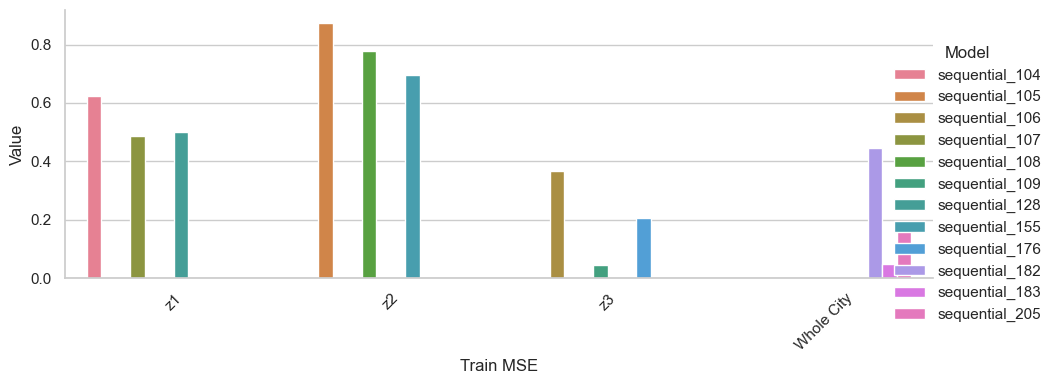

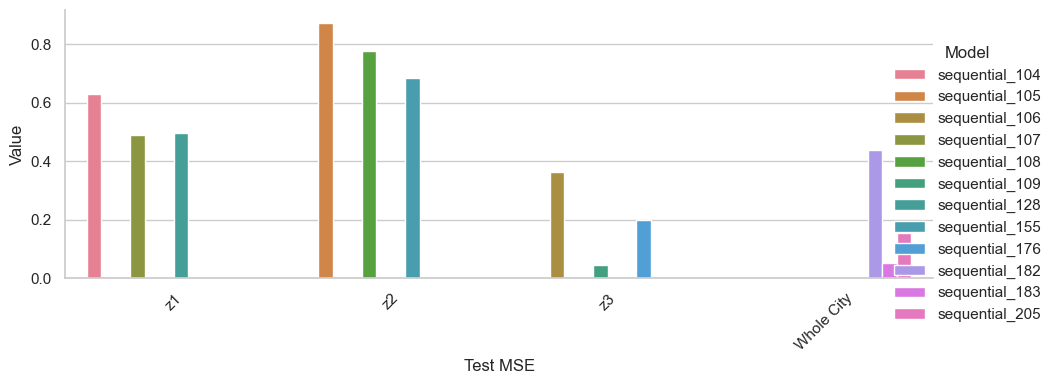

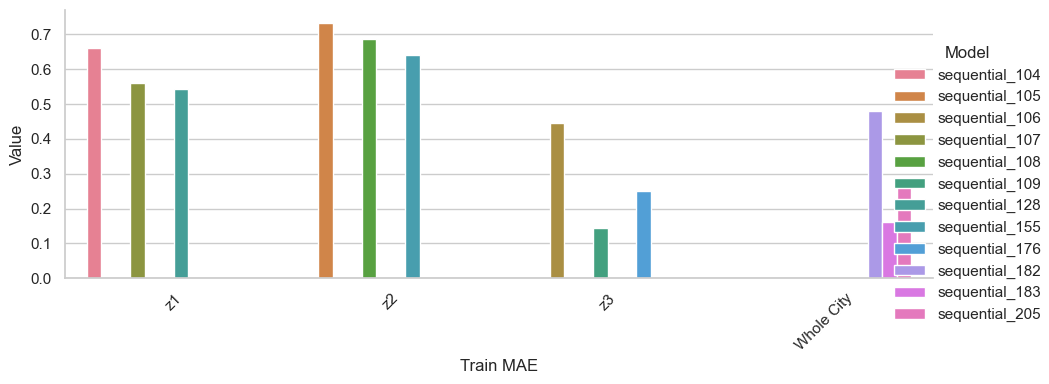

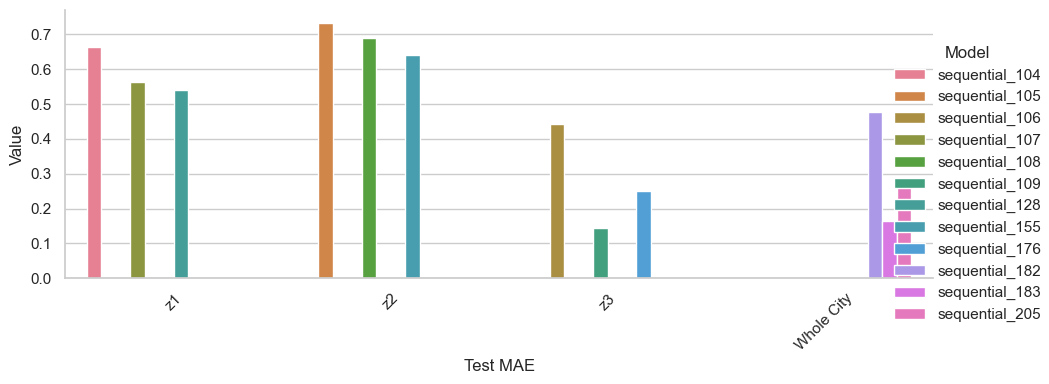

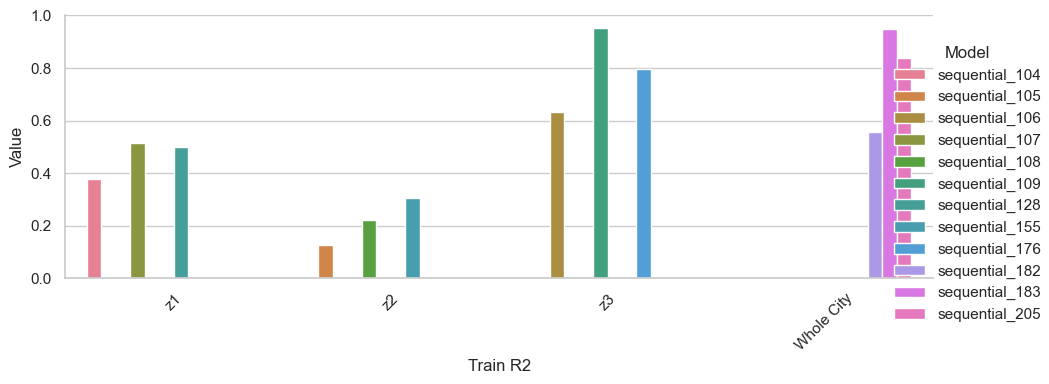

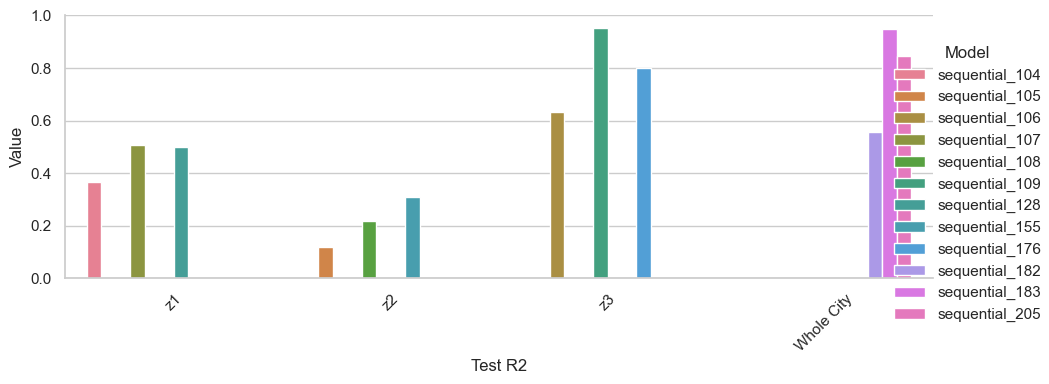

In [54]:
df_melted = preprocess_data(results)

# Plot the results
plot_results(df_melted)

# -----------------------------------------------------------

# Conclusion: Impact of Preprocessing and ANN Model Performance

Our analysis has yielded significant insights into the impact of data preprocessing and the effectiveness of an Artificial Neural Network (ANN) model:

* **Preprocessing Significance:** Data preprocessing played a **critical role** in achieving good performance with the ANN model. 

* **Promising ANN Results:** The trained ANN model achieved promising results on the preprocessed data. It yielded an R-squared (R²) of 0.949166, Mean Absolute Error (MAE) of 0.162980, and Mean Squared Error (MSE) of 0.050358. These metrics indicate a strong correlation between the predicted and actual values, with relatively low errors.

* **Training Time Consideration:** It's important to acknowledge that training an ANN model can be computationally expensive compared to the other models. 

**Overall, these findings demonstrate the effectiveness of:**

* Applying appropriate data preprocessing techniques to improve data quality for ANN models.
* Utilizing ANNs for potentially achieving high accuracy in prediction tasks, as evidenced by the R², MAE, and MSE achieved in this analysis.
* Considering the trade-offs between training time and desired performance when choosing an ANN model.
